In [1]:
"""
------------------------------------------------------------------------------
About
In this data analysis, the proportion of the cannabis-free areas compared to the
total area of each admin area is calculated.

The cannabis-free area is defined by the distance of 100m to schools, kitas,
playgrounds, sports areas, leisure facilities etc. 
--> more about the data in the README
------------------------------------------------------------------------------
"""

'\n------------------------------------------------------------------------------\nAbout\nIn this data analysis, the proportion of the cannabis-free areas compared to the\ntotal area of each admin area is calculated.\n\nThe cannabis-free area is defined by the distance of 100m to schools, kitas,\nplaygrounds, sports areas, leisure facilities etc. \n--> more about the data in the README\n------------------------------------------------------------------------------\n'

In [2]:
"""
------------------------------------------------------------------------------
Libraries
------------------------------------------------------------------------------
"""

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
"""
------------------------------------------------------------------------------
Load GeoJson files
------------------------------------------------------------------------------
"""

admin_areas = gpd.read_file("../data/raw/Prognoseräume.json")

cannabis = gpd.read_file("../data/raw/Cannabis.geojson")

In [4]:
cannabis.head()

id             @id TMC:cid_58:tabcd_1:Class  \
0   relation/4178   relation/4178                     None   
1   relation/7127   relation/7127                     None   
2  relation/22529  relation/22529                     None   
3  relation/27716  relation/27716                     None   
4  relation/31076  relation/31076                     None   

  TMC:cid_58:tabcd_1:LCLversion TMC:cid_58:tabcd_1:LocationCode abandoned  \
0                          None                            None      None   
1                          None                            None      None   
2                          None                            None      None   
3                          None                            None      None   
4                          None                            None      None   

  access access:covid19 addr:city addr:country  ... wheelchair:description:de  \
0   None           None    Berlin           DE  ...                      None   
1   None           None      None         None  ...                      None   
2   None           None      None         None  ...                      None   
3   None           None    Berlin           DE  ...                      None   
4   None           None      None         None  ...                      None   

  wheelchair:step_height   wikidata wikimedia_commons @relations  \
0                   None  Q15058360              None       None   
1                   None   Q1503434              None       None   
2                   None       None              None       None   
3                   None  Q32653621              None       None   
4                   None       None              None       None   

                     wikipedia winter_service  year youtube  \
0            de:Paracelsus-Bad           None  None    None   
1  de:Georg-Schlesinger-Schule           None  None    None   
2                         None           None  None    None   
3                         None           None  None    None   
4                         None           None  None    None   

                                            geometry  
0  POLYGON ((13.3466 52.57539, 13.34656 52.5754, ...  
1  POLYGON ((13.37054 52.5626, 13.37052 52.5626, ...  
2  POLYGON ((13.3432 52.52203, 13.34322 52.52184,...  
3  POLYGON ((13.43234 52.53413, 13.43257 52.53402...  
4  POLYGON ((13.32116 52.49633, 13.32109 52.49595...  

[5 rows x 469 columns]

In [5]:
admin_areas.head()

id pgr_id                   pgr_name  \
0  c_lor_pgr_2021.0370   0370  Südlicher Prenzlauer Berg   
1  c_lor_pgr_2021.0220   0220              Kreuzberg Süd   
2  c_lor_pgr_2021.0760   0760  Marienfelde / Lichtenrade   
3  c_lor_pgr_2021.0520   0520     Wilhelmstadt / Staaken   
4  c_lor_pgr_2021.0330   0330       Nördliches Weißensee   

                             bez       finhalt       stand  \
0                    03 - Pankow  3.031117e+06  01.01.2021   
1  02 - Friedrichshain-Kreuzberg  4.746309e+06  01.01.2021   
2      07 - Tempelhof-Schöneberg  1.919254e+07  01.01.2021   
3                   05 - Spandau  2.301526e+07  01.01.2021   
4                    03 - Pankow  2.222540e+07  01.12.2021   

                                            geometry  
0  MULTIPOLYGON (((13.41975 52.52555, 13.42016 52...  
1  MULTIPOLYGON (((13.40772 52.48875, 13.40789 52...  
2  MULTIPOLYGON (((13.35912 52.4199, 13.35902 52....  
3  MULTIPOLYGON (((13.15724 52.50162, 13.15726 52...  
4  MULTIPOLYGON (((13.43357 52.58232, 13.43362 52...

In [6]:
"""
------------------------------------------------------------------------------
Data exploration
------------------------------------------------------------------------------
"""

cannabis.columns

Index(['id', '@id', 'TMC:cid_58:tabcd_1:Class',
       'TMC:cid_58:tabcd_1:LCLversion', 'TMC:cid_58:tabcd_1:LocationCode',
       'abandoned', 'access', 'access:covid19', 'addr:city', 'addr:country',
       ...
       'wheelchair:description:de', 'wheelchair:step_height', 'wikidata',
       'wikimedia_commons', '@relations', 'wikipedia', 'winter_service',
       'year', 'youtube', 'geometry'],
      dtype='object', length=469)

In [7]:
cannabis.shape

(17031, 469)

In [8]:
"""
------------------------------------------------------------------------------
CSR (coordinate reference system)
------------------------------------------------------------------------------
"""

#check CRS
print(admin_areas.crs)
print(cannabis.crs)

EPSG:4326
EPSG:4326


In [9]:
#convert to ESPG:25833
cannabis = cannabis.to_crs(epsg=25833)

In [10]:
"""
------------------------------------------------------------------------------
Checking invalid geometries
------------------------------------------------------------------------------
"""

#check the dataframe for empty or invalid geometries
print(f"Empty geometry in cannabis: {len(cannabis[cannabis.is_empty])}")
print(f"Invalid geometry in cannabis: {len(cannabis[~cannabis.is_valid])}")

Empty geometry in cannabis: 0
Invalid geometry in cannabis: 2


In [11]:
#fix invalid geometries by applying a zero-width buffer
cannabis["geometry"] = cannabis["geometry"].buffer(0)

In [12]:
print(f"Invalid geometry in cannabis: {len(cannabis[~cannabis.is_valid])}")

Invalid geometry in cannabis: 0


In [13]:
#100m around Kitas, Schools, Youth centre, Playgrounds and Sports pitches etc.
#add column geomety_100
cannabis["geometry_100"] = cannabis["geometry"].buffer(100)

gdf_Cannabis = cannabis.drop(columns="geometry")
gdf_Cannabis = gdf_Cannabis.set_geometry("geometry_100")

gdf_Cannabis.head()

id             @id TMC:cid_58:tabcd_1:Class  \
0   relation/4178   relation/4178                     None   
1   relation/7127   relation/7127                     None   
2  relation/22529  relation/22529                     None   
3  relation/27716  relation/27716                     None   
4  relation/31076  relation/31076                     None   

  TMC:cid_58:tabcd_1:LCLversion TMC:cid_58:tabcd_1:LocationCode abandoned  \
0                          None                            None      None   
1                          None                            None      None   
2                          None                            None      None   
3                          None                            None      None   
4                          None                            None      None   

  access access:covid19 addr:city addr:country  ... wheelchair:description:de  \
0   None           None    Berlin           DE  ...                      None   
1   None           None      None         None  ...                      None   
2   None           None      None         None  ...                      None   
3   None           None    Berlin           DE  ...                      None   
4   None           None      None         None  ...                      None   

  wheelchair:step_height   wikidata wikimedia_commons @relations  \
0                   None  Q15058360              None       None   
1                   None   Q1503434              None       None   
2                   None       None              None       None   
3                   None  Q32653621              None       None   
4                   None       None              None       None   

                     wikipedia winter_service  year youtube  \
0            de:Paracelsus-Bad           None  None    None   
1  de:Georg-Schlesinger-Schule           None  None    None   
2                         None           None  None    None   
3                         None           None  None    None   
4                         None           None  None    None   

                                        geometry_100  
0  POLYGON ((387853.402 5826323.56, 387853.876 58...  
1  POLYGON ((389473.74 5824607.431, 389465.915 58...  
2  POLYGON ((387491.585 5820385.724, 387491.453 5...  
3  POLYGON ((393606.719 5821524.077, 393599.303 5...  
4  POLYGON ((385930.726 5817581.095, 385932.459 5...  

[5 rows x 469 columns]

In [14]:
#ensure both GeoDataFrames have the same CRS (epsg=25833)
if gdf_Cannabis.crs != admin_areas.crs:
    admin_areas = admin_areas.to_crs(gdf_Cannabis.crs)

In [15]:
#check CRS
print(admin_areas.crs)
print(gdf_Cannabis.crs)

EPSG:25833
EPSG:25833


<Axes: >

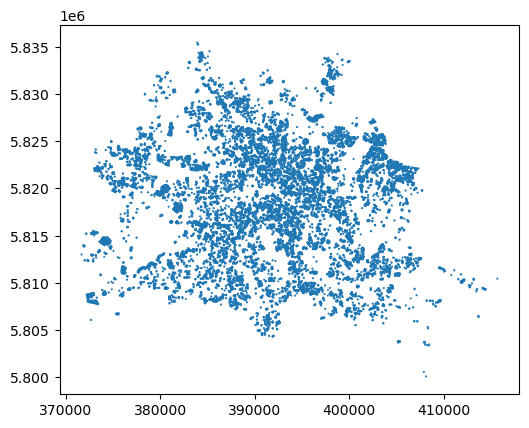

In [16]:
gdf_Cannabis.plot()

/var/folders/_f/022l68353h9c2pr_3t55ns1m0000gn/T/ipykernel_5910/114645944.py:5: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


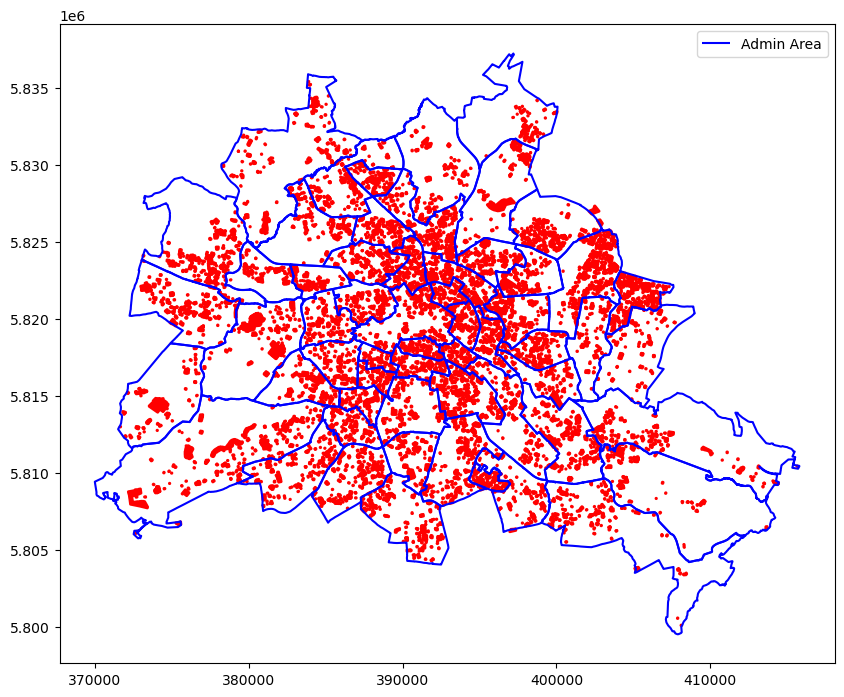

In [17]:
#test plot
fig, ax = plt.subplots(figsize=(10,10))
admin_areas.boundary.plot(ax=ax, color="blue", label="Admin Area")
gdf_Cannabis.plot(ax=ax, color="red", label="cannabis free")
plt.legend()
plt.show()

In [18]:
#check one admin area
geometry_union = gdf_Cannabis["geometry_100"].union_all()

intersections = geometry_union.intersection(admin_areas.iloc[0].geometry) 
print(intersections)

Cannabis_free_m2 = intersections.area

Cannabis_free_m2

MULTIPOLYGON (((393202.4338074237 5822418.888937956, 393208.8214484195 5822411.765019048, 393214.4989925694 5822404.063222471, 393219.41446072026 5822395.854059848, 393223.5228506904 5822387.212687853, 393226.78654927487 5822378.218220129, 393229.1756766023 5822368.953002986, 393229.5087645628 5822366.844007806, 393232.7639737277 5822369.608149721, 393240.89279402193 5822375.230668573, 393249.5369510707 5822380.023265626, 393258.6119997256 5822383.939121792, 393268.0292854391 5822386.9399829, 393277.69681033504 5822388.996533408, 393287.5201319396 5822390.088682782, 393297.4032857942 5822390.205761768, 393307.24972293625 5822389.346626617, 393316.96325309057 5822387.5196702555, 393326.44898435596 5822384.742740303, 393335.61425020854 5822381.042964708, 393344.369514765 5822376.45648674, 393345.0614298162 5822376.04923264, 393345.70382797084 5822376.048287208, 393355.52815616754 5822375.060076474, 393365.207137722 5822373.107821101, 393374.646408386 5822370.210554406, 393383.7539409484 

2265345.4071518704

In [19]:
gdf_Cannabis.head()

id             @id TMC:cid_58:tabcd_1:Class  \
0   relation/4178   relation/4178                     None   
1   relation/7127   relation/7127                     None   
2  relation/22529  relation/22529                     None   
3  relation/27716  relation/27716                     None   
4  relation/31076  relation/31076                     None   

  TMC:cid_58:tabcd_1:LCLversion TMC:cid_58:tabcd_1:LocationCode abandoned  \
0                          None                            None      None   
1                          None                            None      None   
2                          None                            None      None   
3                          None                            None      None   
4                          None                            None      None   

  access access:covid19 addr:city addr:country  ... wheelchair:description:de  \
0   None           None    Berlin           DE  ...                      None   
1   None           None      None         None  ...                      None   
2   None           None      None         None  ...                      None   
3   None           None    Berlin           DE  ...                      None   
4   None           None      None         None  ...                      None   

  wheelchair:step_height   wikidata wikimedia_commons @relations  \
0                   None  Q15058360              None       None   
1                   None   Q1503434              None       None   
2                   None       None              None       None   
3                   None  Q32653621              None       None   
4                   None       None              None       None   

                     wikipedia winter_service  year youtube  \
0            de:Paracelsus-Bad           None  None    None   
1  de:Georg-Schlesinger-Schule           None  None    None   
2                         None           None  None    None   
3                         None           None  None    None   
4                         None           None  None    None   

                                        geometry_100  
0  POLYGON ((387853.402 5826323.56, 387853.876 58...  
1  POLYGON ((389473.74 5824607.431, 389465.915 58...  
2  POLYGON ((387491.585 5820385.724, 387491.453 5...  
3  POLYGON ((393606.719 5821524.077, 393599.303 5...  
4  POLYGON ((385930.726 5817581.095, 385932.459 5...  

[5 rows x 469 columns]

In [20]:
"""
------------------------------------------------------------------------------
Function
cannabis free area
------------------------------------------------------------------------------
"""


def calculate_intersection_area(admin_area, gdf_Cannabis):

    #unite all cannabis free areas to prevent double counting of overlapping areas
    geometry_union = gdf_Cannabis["geometry_100"].union_all()
    #find intersections between the geometry_union and admin areas
    intersections = geometry_union.intersection(admin_area.geometry)
     
    #calculate total area, .sum() not needed
    cannabisFree_m2 = int(intersections.area if not intersections.is_empty else 0)
    
    #admin areas in m2
    adminArea_m2 = round(admin_area.geometry.area)
    
    #percent
    cannabisFree_perc = round(((cannabisFree_m2 / adminArea_m2) * 100), 1)
    
    print(f"Admin Area: {admin_area.pgr_name}, Admin area in m²: {adminArea_m2}, Cannabis free area in m²: {cannabisFree_m2}, Cannabis free area in percent: {cannabisFree_perc}%")
    
    return cannabisFree_m2, cannabisFree_perc

In [21]:
#calculation of cannabisFree_m2 and percent for each administrative area
admin_areas[["cannabisFreeArea_m2","cannabisFreeArea_perc"]] = admin_areas.apply(
    lambda row: calculate_intersection_area(row, gdf_Cannabis), axis=1, result_type="expand" #result_type="expand" for multiple return values
)

Admin Area: Südlicher Prenzlauer Berg, Admin area in m²: 3029501, Cannabis free area in m²: 2265345, Cannabis free area in percent: 74.8%
Admin Area: Kreuzberg Süd, Admin area in m²: 4743826, Cannabis free area in m²: 3133298, Cannabis free area in percent: 66.1%
Admin Area: Marienfelde / Lichtenrade, Admin area in m²: 19182609, Cannabis free area in m²: 5929822, Cannabis free area in percent: 30.9%
Admin Area: Wilhelmstadt / Staaken, Admin area in m²: 23005237, Cannabis free area in m²: 6240512, Cannabis free area in percent: 27.1%
Admin Area: Nördliches Weißensee, Admin area in m²: 22213197, Cannabis free area in m²: 3781349, Cannabis free area in percent: 17.0%
Admin Area: Tempelhof, Admin area in m²: 13662083, Cannabis free area in m²: 3908259, Cannabis free area in percent: 28.6%
Admin Area: Lichtenberg Nord, Admin area in m²: 9535798, Cannabis free area in m²: 4783977, Cannabis free area in percent: 50.2%
Admin Area: Lichtenberg Mitte, Admin area in m²: 7585331, Cannabis free are

In [22]:
#subset
df_cannabisFreeArea = admin_areas[["pgr_id", "pgr_name", "cannabisFreeArea_m2", "cannabisFreeArea_perc"]]

df_cannabisFreeArea.head()


pgr_id                   pgr_name  cannabisFreeArea_m2  \
0   0370  Südlicher Prenzlauer Berg            2265345.0   
1   0220              Kreuzberg Süd            3133298.0   
2   0760  Marienfelde / Lichtenrade            5929822.0   
3   0520     Wilhelmstadt / Staaken            6240512.0   
4   0330       Nördliches Weißensee            3781349.0   

   cannabisFreeArea_perc  
0                   74.8  
1                   66.1  
2                   30.9  
3                   27.1  
4                   17.0

In [23]:
#sort descending
df_cannabisFreeArea.sort_values(by="cannabisFreeArea_perc", ascending=False, inplace=True)
df_cannabisFreeArea.reset_index(drop=True, inplace=True)

#int
df_cannabisFreeArea["cannabisFreeArea_m2"] = df_cannabisFreeArea["cannabisFreeArea_m2"].astype(int)

df_cannabisFreeArea

/var/folders/_f/022l68353h9c2pr_3t55ns1m0000gn/T/ipykernel_5910/2638304788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cannabisFreeArea.sort_values(by="cannabisFreeArea_perc", ascending=False, inplace=True)
/var/folders/_f/022l68353h9c2pr_3t55ns1m0000gn/T/ipykernel_5910/2638304788.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cannabisFreeArea["cannabisFreeArea_m2"] = df_cannabisFreeArea["cannabisFreeArea_m2"].astype(int)


pgr_id                          pgr_name  cannabisFreeArea_m2  \
0    0830                      Gropiusstadt              2146826   
1    0230                     Kreuzberg Ost              2128478   
2    0210                    Kreuzberg Nord              2258290   
3    1020                       Hellersdorf              6116720   
4    0370         Südlicher Prenzlauer Berg              2265345   
5    0130                     Gesundbrunnen              4251517   
6    0720                    Schöneberg Süd              2254763   
7    0220                     Kreuzberg Süd              3133298   
8    0360        Nördlicher Prenzlauer Berg              5296290   
9    1260                Märkisches Viertel              3058207   
10   0240               Friedrichshain West              2918938   
11   0250                Friedrichshain Ost              3278920   
12   0710                   Schöneberg Nord              1715462   
13   0810                          Neukölln              6804278   
14   0730                         Friedenau              2647781   
15   1140                 Lichtenberg Mitte              4343791   
16   0350               Südliches Weißensee              4234413   
17   0140                           Wedding              4960491   
18   0610                          Steglitz              3472546   
19   0340                  Südliches Pankow              6529728   
20   1130                  Lichtenberg Nord              4783977   
21   0120                            Moabit              4037117   
22   1210                 Reinickendorf Ost              3689106   
23   1010                           Marzahn              8680379   
24   0450               Wilmersdorf Zentrum              3749041   
25   0430            Charlottenburg Zentrum              3826210   
26   1120              Hohenschönhausen Süd              3808157   
27   0110                           Zentrum              6299810   
28   0620         Lankwitz/Lichterfelde Ost              5795206   
29   0410               Charlottenburg Nord              2221783   
30   0820                      Britz/Buckow              6542047   
31   1150                   Lichtenberg Süd              3290991   
32   0750                        Mariendorf              3320170   
33   0440                   Wilmersdorf Süd              3939218   
34   0920                Treptow-Köpenick 2              6329620   
35   0630  Zehlendorf Süd/Lichterfelde West              5878219   
36   1110             Hohenschönhausen Nord              5261686   
37   0760         Marienfelde / Lichtenrade              5929822   
38   0740                         Tempelhof              3908259   
39   0910                Treptow-Köpenick 1              4891210   
40   1250              Wittenau/Borsigwalde              4338258   
41   0520            Wilhelmstadt / Staaken              6240512   
42   0840                 Buckow Nord/Rudow              3487952   
43   1030                          Biesdorf              2932809   
44   0530         Haselhorst / Siemensstadt              2447660   
45   1220                             Tegel              4026908   
46   0510              Spandau Mitte / Nord              7188173   
47   0420               Charlottenburg West              5680720   
48   0640           Zehlendorf Nord/Wannsee             10689706   
49   0330              Nördliches Weißensee              3781349   
50   1040               Kaulsdorf/Mahlsdorf              3226829   
51   0320                 Nördliches Pankow              3754940   
52   0540                    Gatow / Kladow              3495915   
53   1240                     Grüner Norden              5748467   
54   0930                Treptow-Köpenick 3              5384304   
55   0950                Treptow-Köpenick 5              5580661   
56   0310                              Buch              2170969   
57   0940                Treptow-Köpenick 4              34

In [24]:
#csv
df_cannabisFreeArea.to_csv("../data/csv/cannabisFreeArea.csv", index=False)

In [25]:
"""
------------------------------------------------------------------------------
MAPS

GeoJSON and SVG files for the intersections per admin area
------------------------------------------------------------------------------
"""

'\n------------------------------------------------------------------------------\nMAPS\n\nGeoJSON and SVG files for the intersections per admin area\n------------------------------------------------------------------------------\n'

In [26]:
gdf_Cannabis.head()

id             @id TMC:cid_58:tabcd_1:Class  \
0   relation/4178   relation/4178                     None   
1   relation/7127   relation/7127                     None   
2  relation/22529  relation/22529                     None   
3  relation/27716  relation/27716                     None   
4  relation/31076  relation/31076                     None   

  TMC:cid_58:tabcd_1:LCLversion TMC:cid_58:tabcd_1:LocationCode abandoned  \
0                          None                            None      None   
1                          None                            None      None   
2                          None                            None      None   
3                          None                            None      None   
4                          None                            None      None   

  access access:covid19 addr:city addr:country  ... wheelchair:description:de  \
0   None           None    Berlin           DE  ...                      None   
1   None           None      None         None  ...                      None   
2   None           None      None         None  ...                      None   
3   None           None    Berlin           DE  ...                      None   
4   None           None      None         None  ...                      None   

  wheelchair:step_height   wikidata wikimedia_commons @relations  \
0                   None  Q15058360              None       None   
1                   None   Q1503434              None       None   
2                   None       None              None       None   
3                   None  Q32653621              None       None   
4                   None       None              None       None   

                     wikipedia winter_service  year youtube  \
0            de:Paracelsus-Bad           None  None    None   
1  de:Georg-Schlesinger-Schule           None  None    None   
2                         None           None  None    None   
3                         None           None  None    None   
4                         None           None  None    None   

                                        geometry_100  
0  POLYGON ((387853.402 5826323.56, 387853.876 58...  
1  POLYGON ((389473.74 5824607.431, 389465.915 58...  
2  POLYGON ((387491.585 5820385.724, 387491.453 5...  
3  POLYGON ((393606.719 5821524.077, 393599.303 5...  
4  POLYGON ((385930.726 5817581.095, 385932.459 5...  

[5 rows x 469 columns]

In [27]:
#intersections admin areas with cannabis free areas
admin_geometry = admin_areas.geometry
geometry_union = gdf_Cannabis["geometry_100"].union_all()
intersections_Cannabis = admin_geometry.intersection(geometry_union)
intersections_Cannabis

0     MULTIPOLYGON (((393177.826 5820946.096, 393175...
1     MULTIPOLYGON (((392294.499 5816510.698, 392284...
2     MULTIPOLYGON (((388111.755 5808843.407, 388118...
3     MULTIPOLYGON (((376603.895 5818224.129, 376585...
4     MULTIPOLYGON (((393501.036 5825648.236, 393501...
5     MULTIPOLYGON (((389076.399 5811997.749, 389025...
6     MULTIPOLYGON (((396909.42 5821463.45, 397012.0...
7     MULTIPOLYGON (((397708.784 5818550.24, 397712....
8     MULTIPOLYGON (((405800.765 5820592.183, 405797...
9     MULTIPOLYGON (((400051.206 5833583.946, 400050...
10    MULTIPOLYGON (((398153.867 5824697.4, 398131.6...
11    MULTIPOLYGON (((404951.561 5814678.403, 404925...
12    MULTIPOLYGON (((399862.335 5810759.761, 399847...
13    MULTIPOLYGON (((386547.982 5824815.207, 386546...
14    MULTIPOLYGON (((391870.272 5810567.788, 391863...
15    MULTIPOLYGON (((397095.156 5816258.093, 397068...
16    MULTIPOLYGON (((391339.111 5824226.082, 391339...
17    MULTIPOLYGON (((386371.802 5822786.617, 38

In [28]:
"""
------------------------------------------------------------------------------
Functions
- extract polygons from intersection
- cannabis free area per admin area, svg and geojson
------------------------------------------------------------------------------
"""

def extract_polygons(intersections):
    all_polygons = []
    if intersections.geom_type == "MultiPolygon":
        for poly in intersections.geoms:
            if not poly.is_empty:
                all_polygons.append(poly)
    elif intersections.geom_type == "Polygon":
        if not intersections.is_empty:
            all_polygons.append(intersections)
    return all_polygons


def create_cannabisGeom(admin_area, gdf_Cannabis):

    admin_geometry = admin_area.geometry
    Prognoseraum = admin_area.get("pgr_name").replace(" ", "_").replace("/", "_").replace(";", "_")

    #unite all cannabis free areas to prevent double counting of overlapping areas
    geometry_union = gdf_Cannabis["geometry_100"].union_all()

    #find intersections between the Cannabis GeoDataFrame and the admin area geometry
    intersections_Cannabis = admin_geometry.intersection(geometry_union)

    #extract all polygons from intersection
    all_polygons = extract_polygons(intersections_Cannabis)

    #Geo Data Frame of the intersections
    if all_polygons: 
        gdf_intersections_Cannabis = gpd.GeoDataFrame(geometry=all_polygons, crs=gdf_Cannabis.crs)
        #convert espg=4326 (for datawrapper)
        gdf_intersections_Cannabis = gdf_intersections_Cannabis.to_crs(epsg=4326)
        #save as geojson
        gdf_intersections_Cannabis.to_file(f"../GeoJSON/cannabis/{Prognoseraum}_Cannabis.geojson", driver="GeoJSON")

    #Geo Data Frame for the admin area
    gdf_admin = gpd.GeoDataFrame({"geometry": [admin_geometry]}, crs=gdf_Cannabis.crs)

    #plot admin area
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_admin.plot(ax=ax, color="lightgrey")

    #convert back to espg=25833
    gdf_intersections_Cannabis = gdf_intersections_Cannabis.to_crs(epsg=25833)
    #plot cannabis free area within the admin areas
    gdf_intersections_Cannabis.plot(ax=ax, color="red", alpha=0.7, edgecolor="black", linewidth=0.5)

    #add text
    centroid = admin_geometry.centroid
    ax.text(centroid.x, centroid.y, Prognoseraum, fontsize=12, ha="center", va="center")

    #save as svg
    fig.savefig(f"../SVG/cannabis/{Prognoseraum}_Cannabis.svg", format="svg")

    plt.show()
    plt.close(fig)



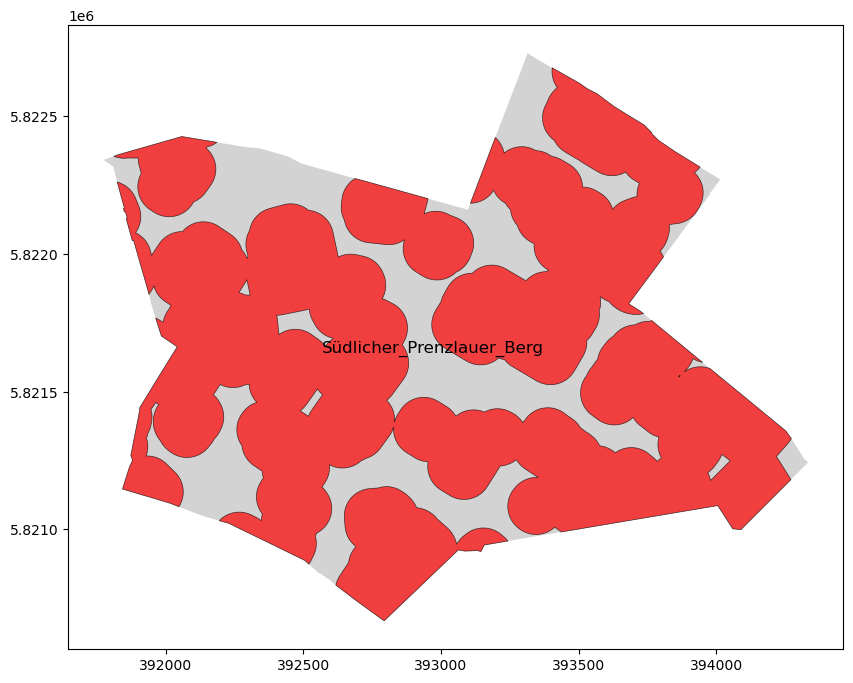

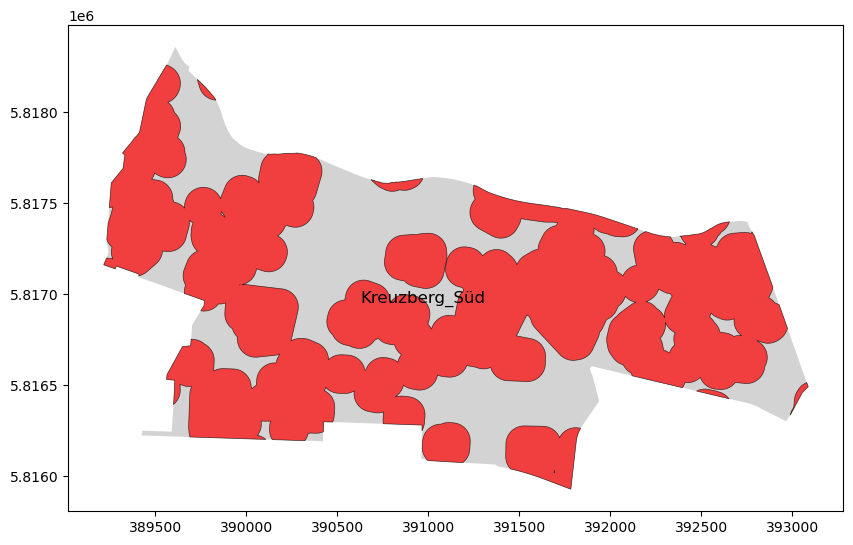

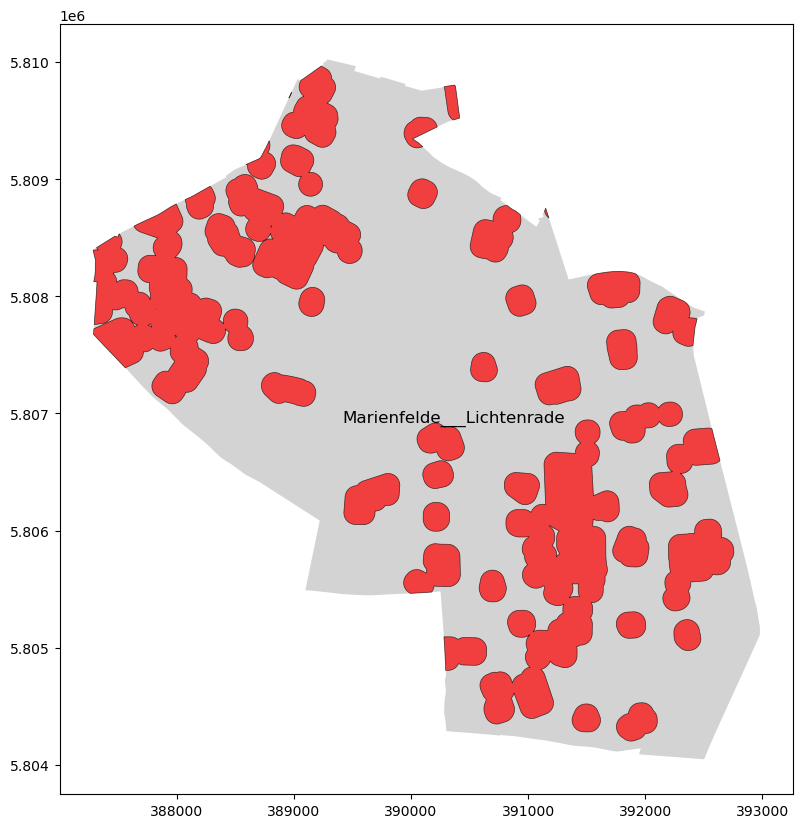

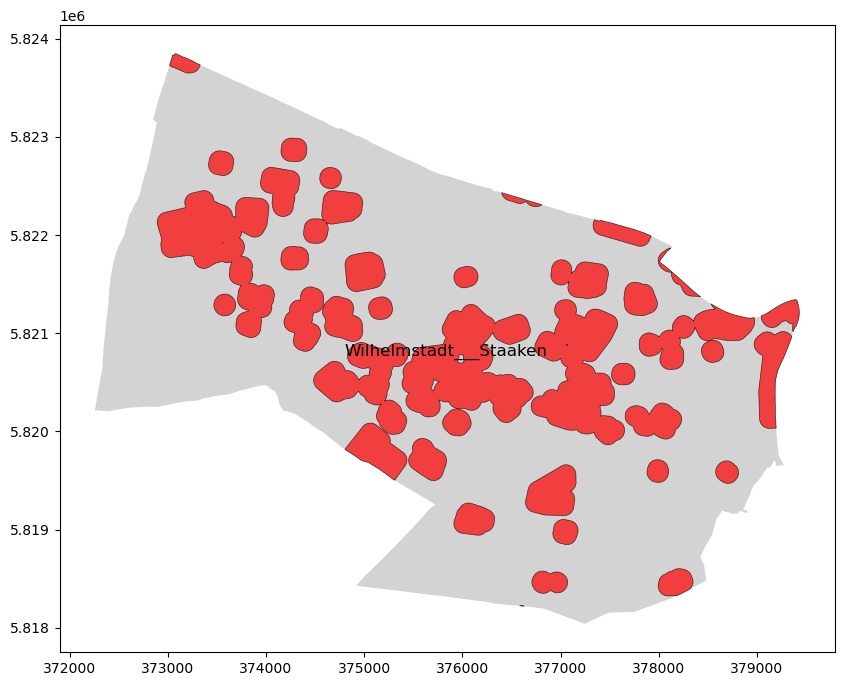

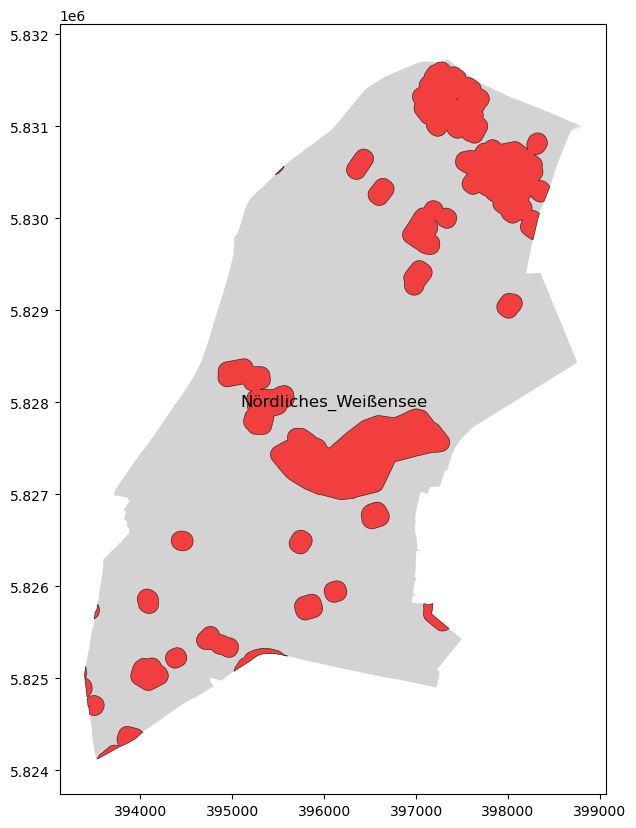

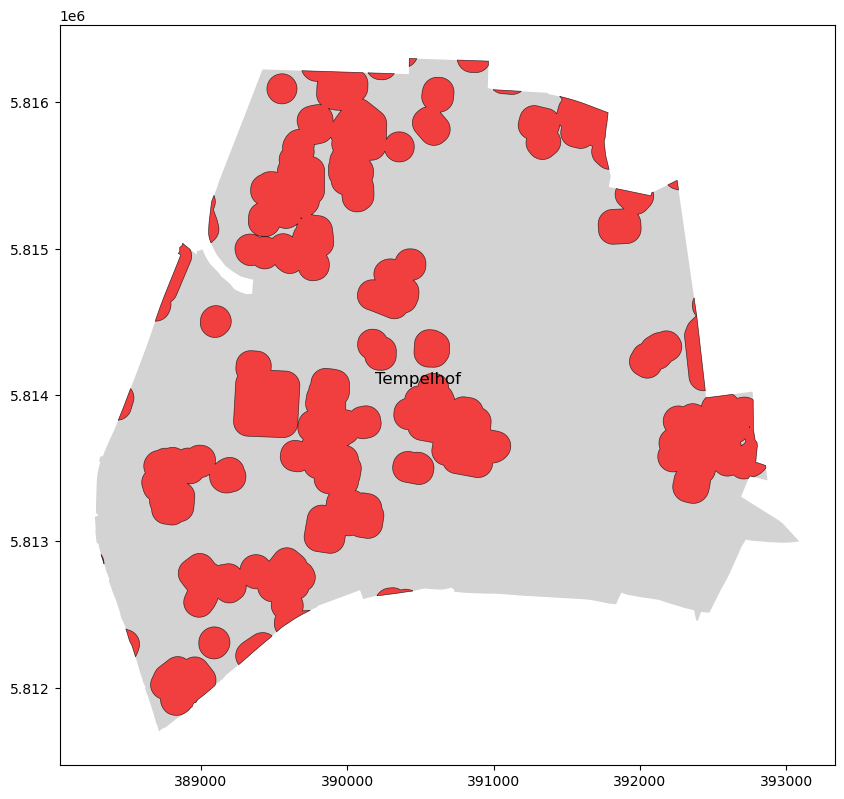

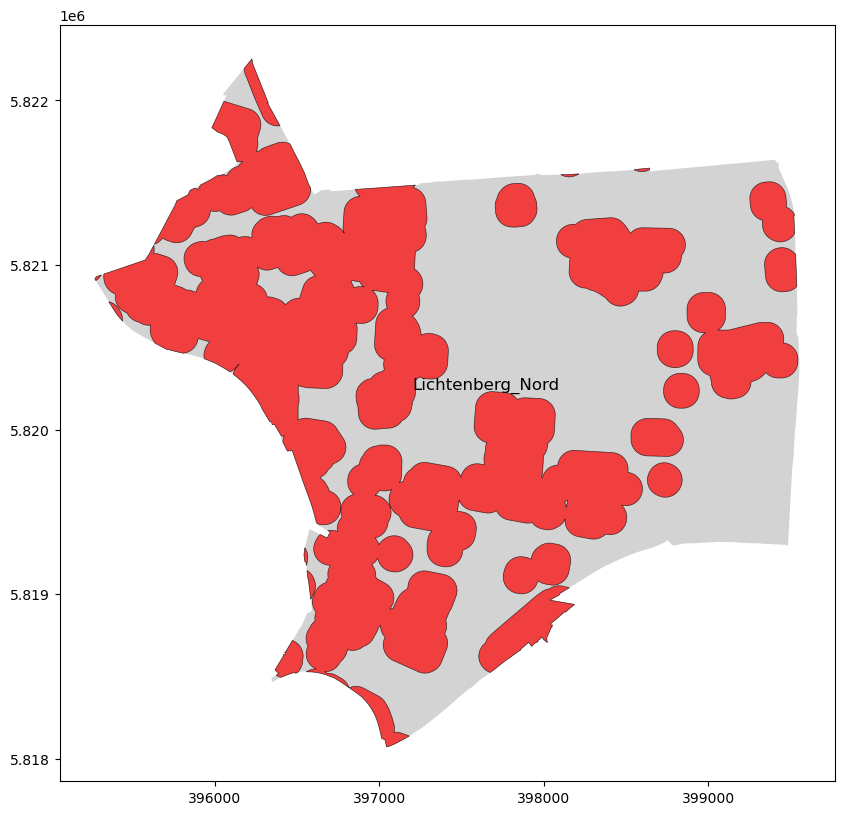

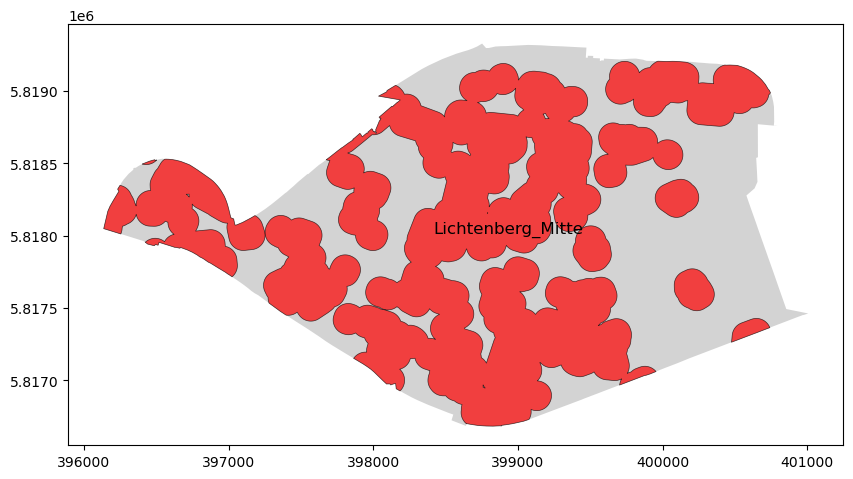

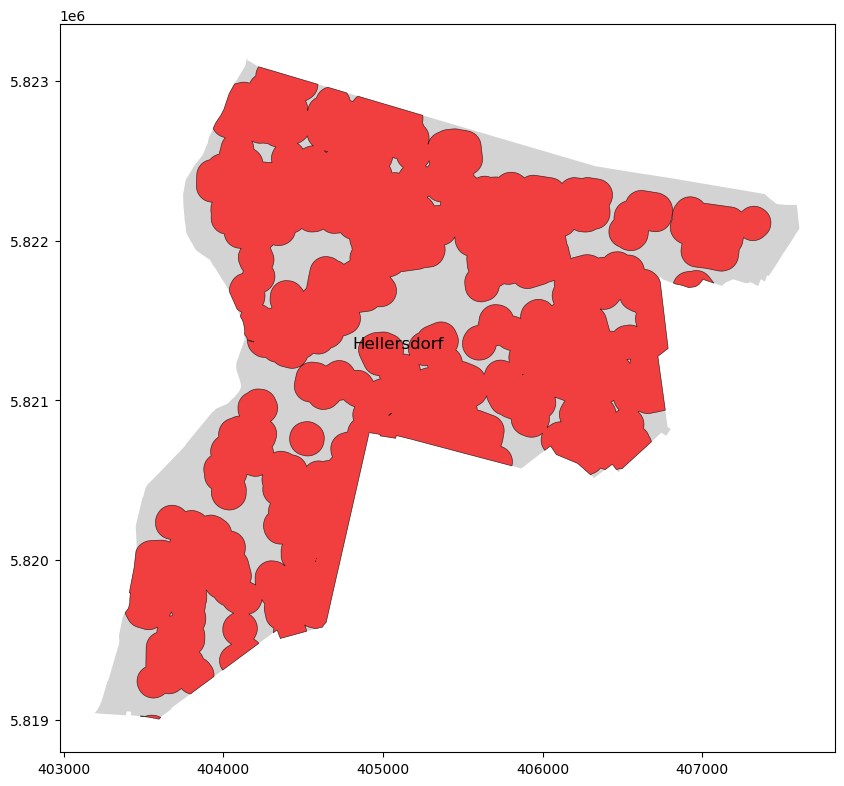

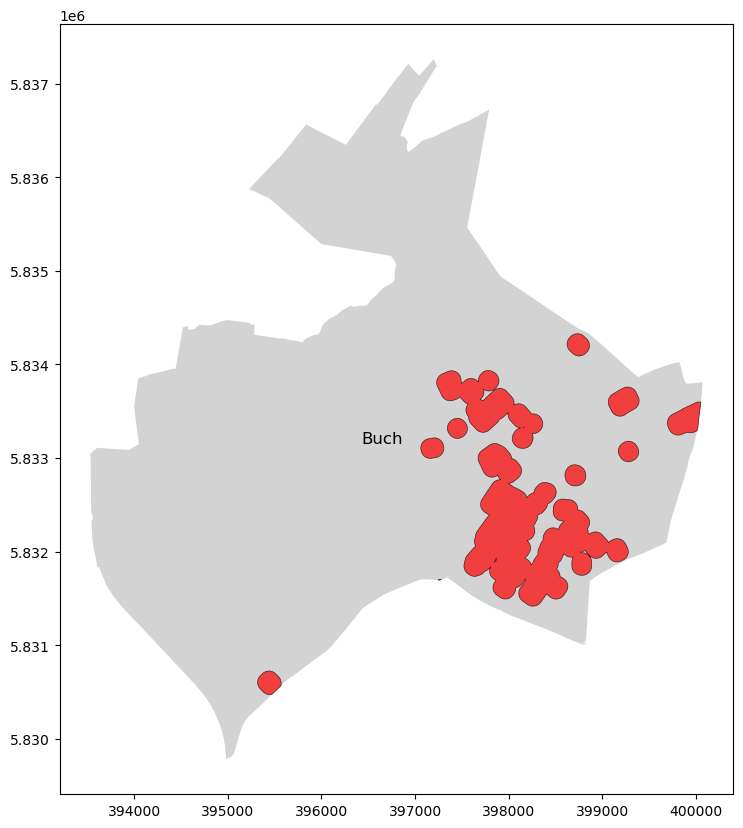

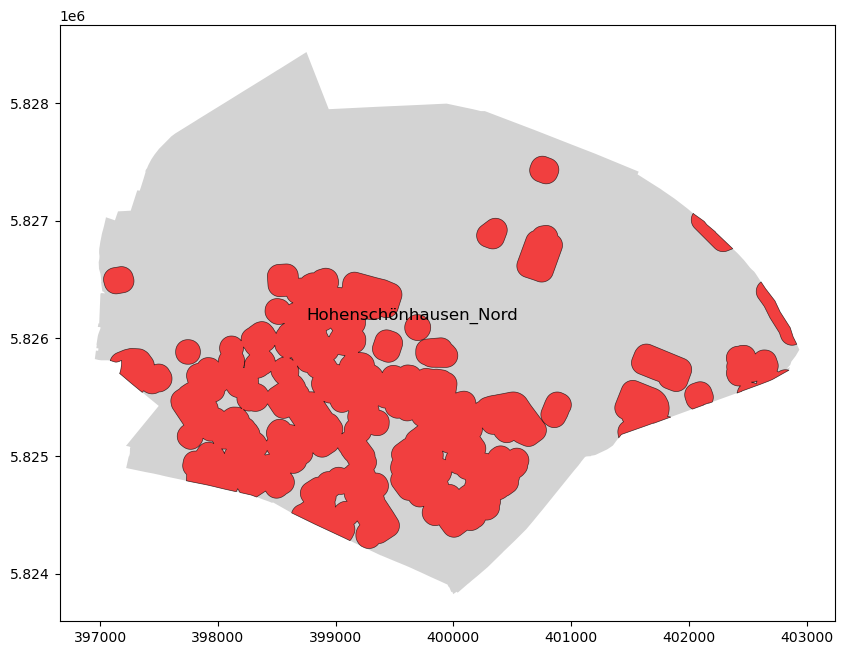

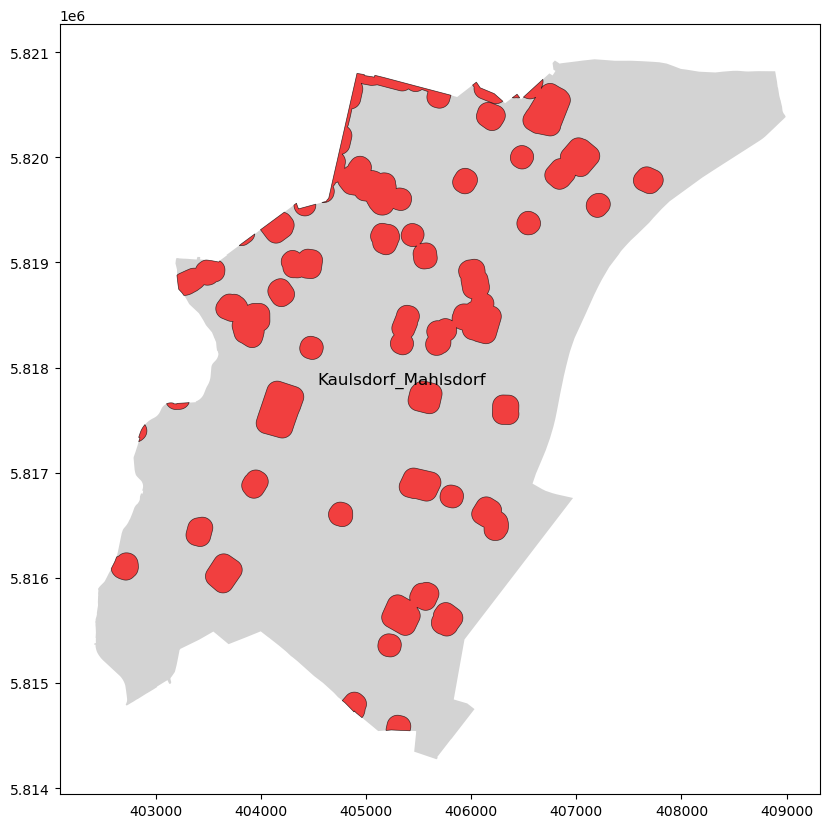

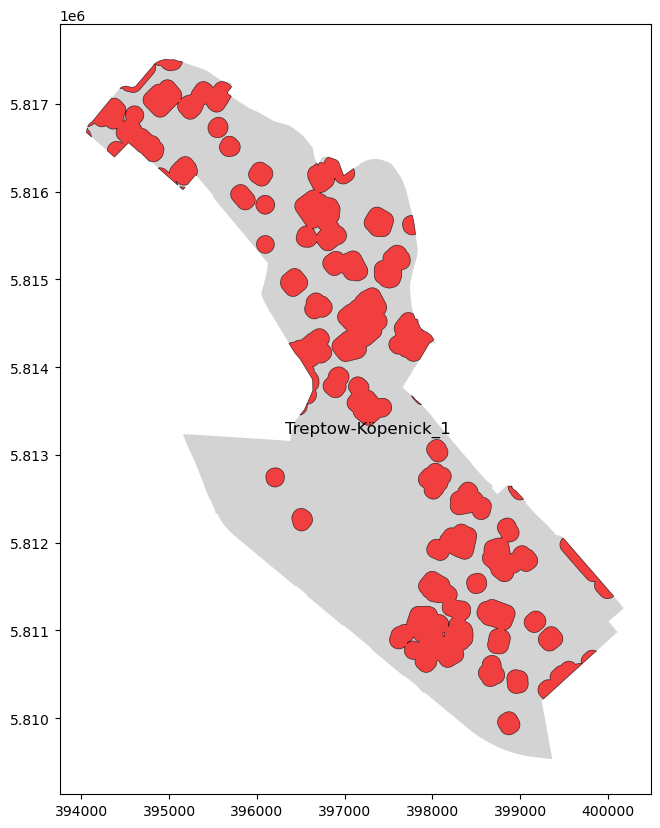

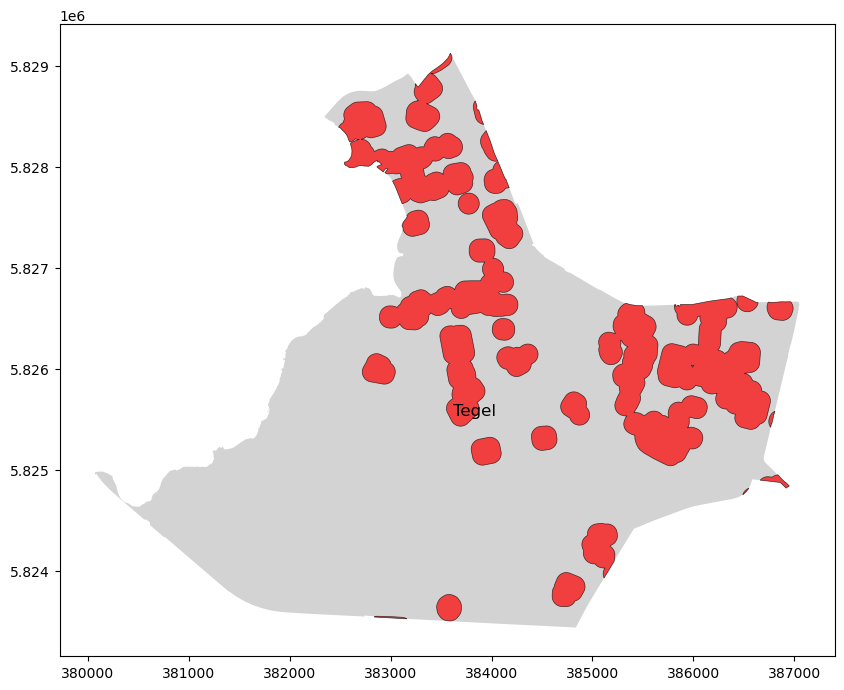

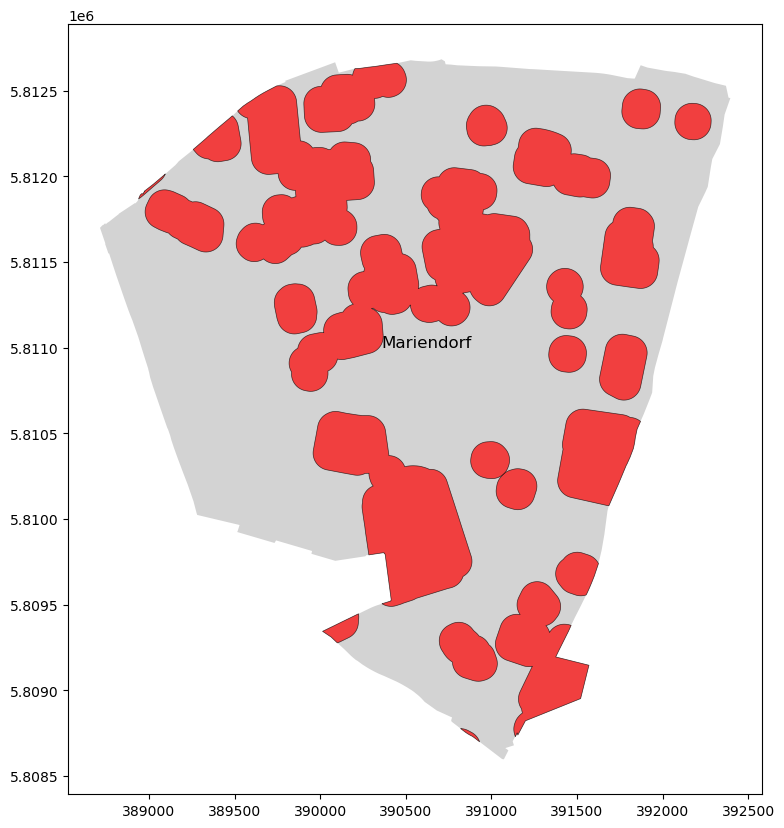

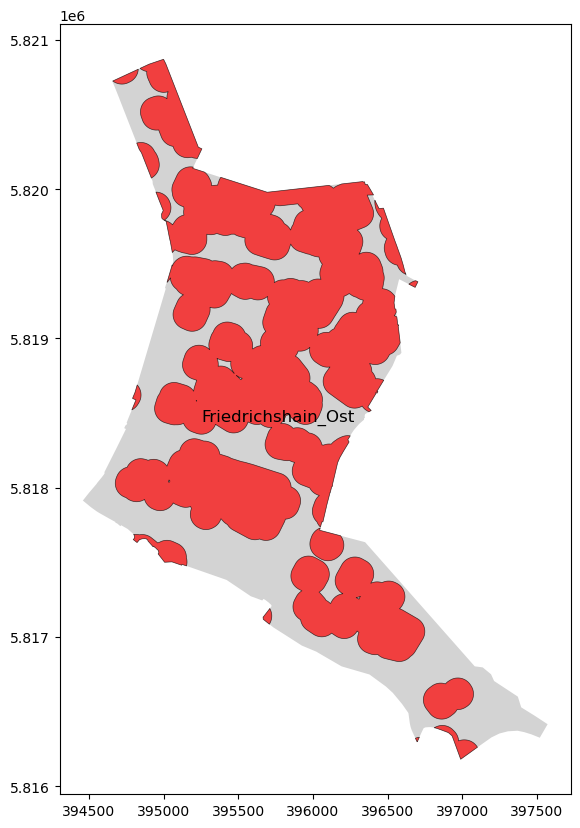

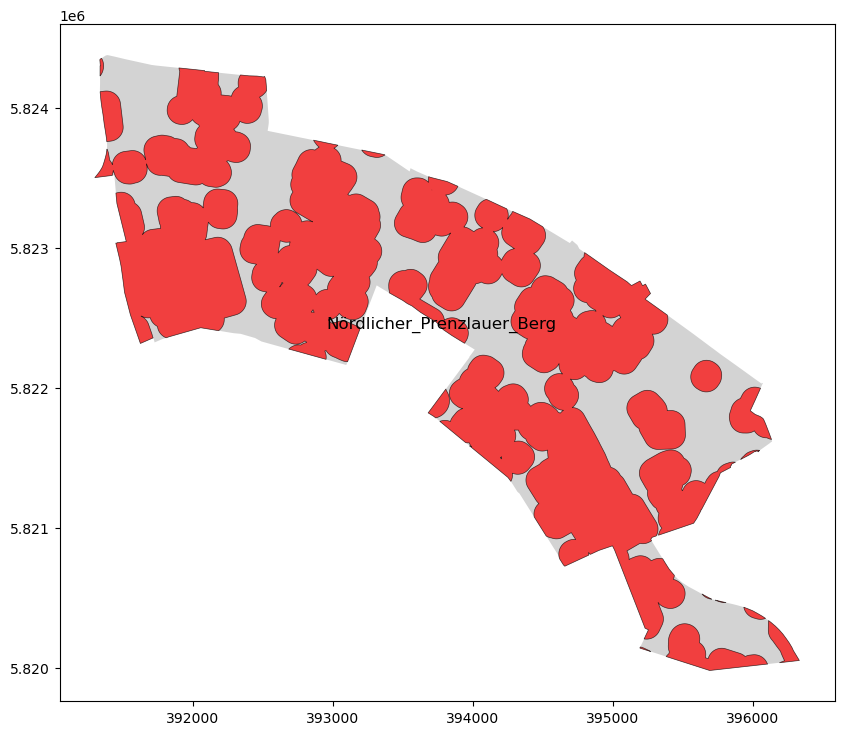

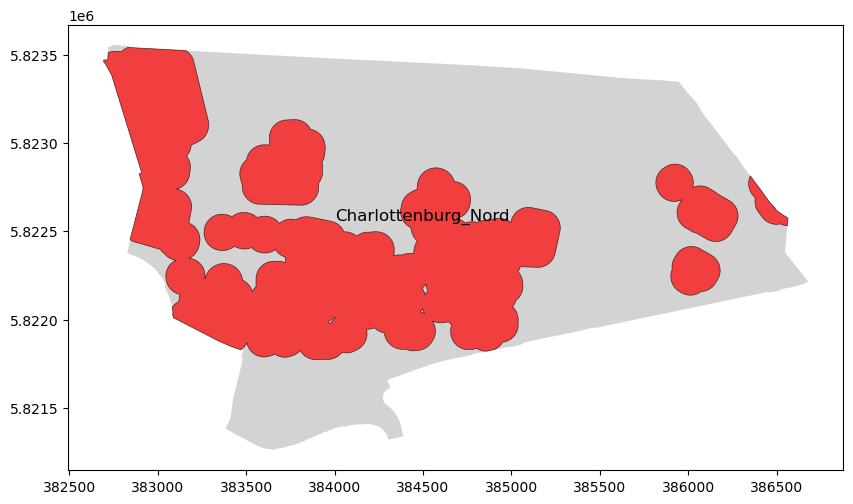

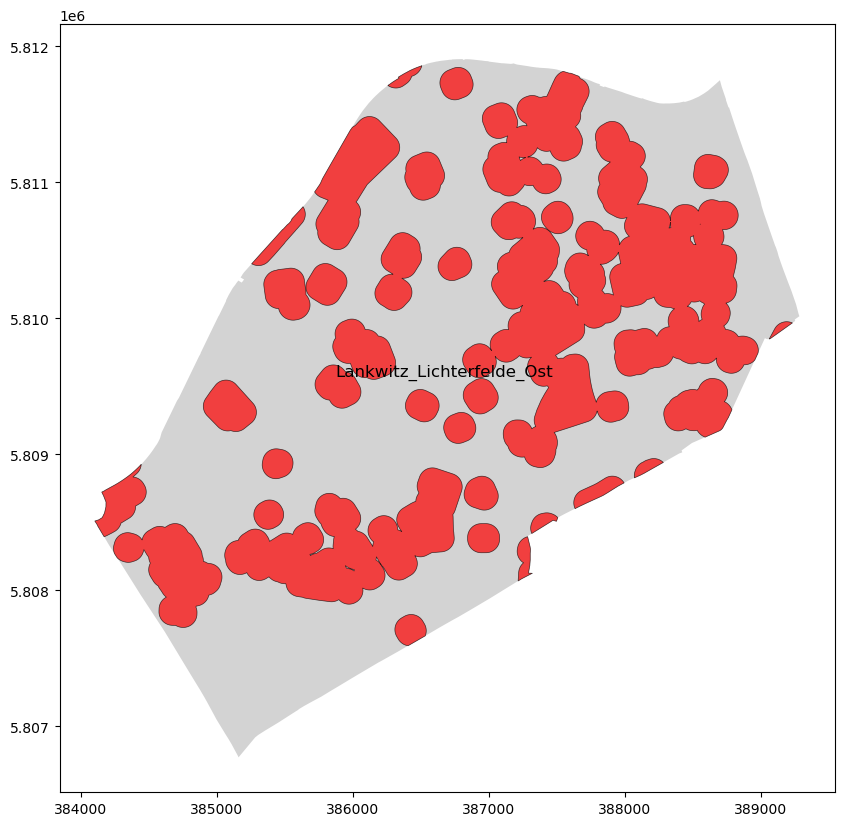

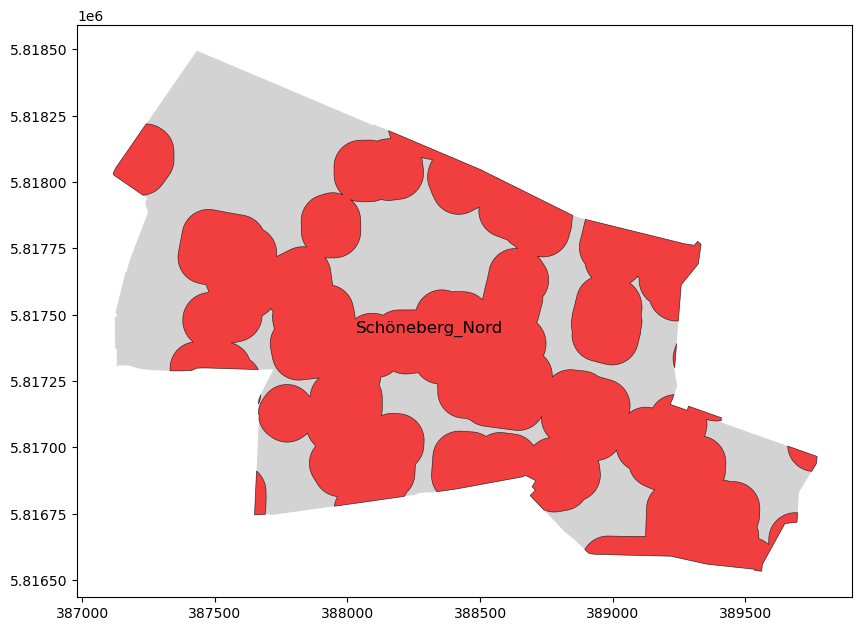

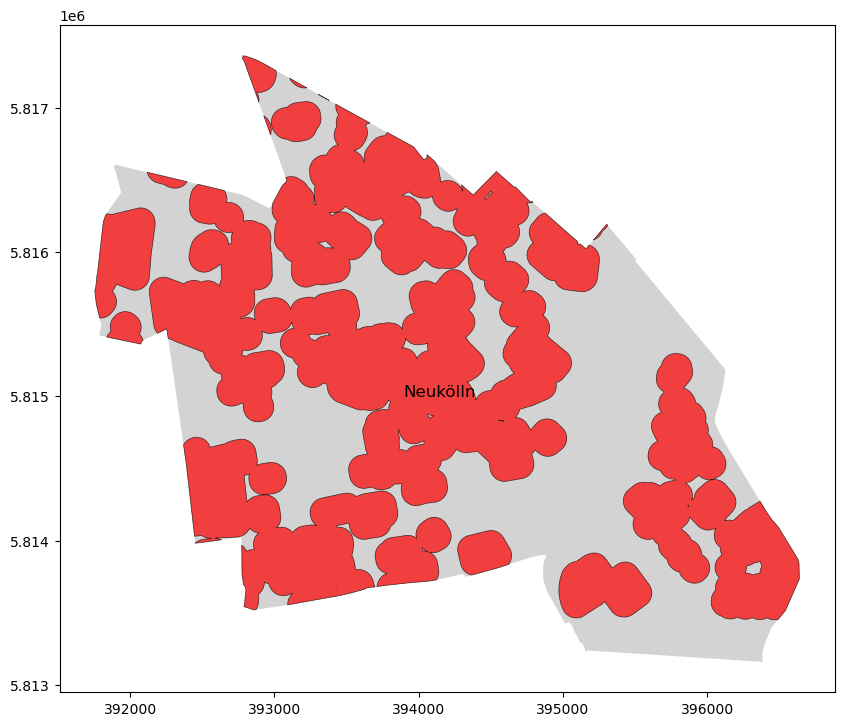

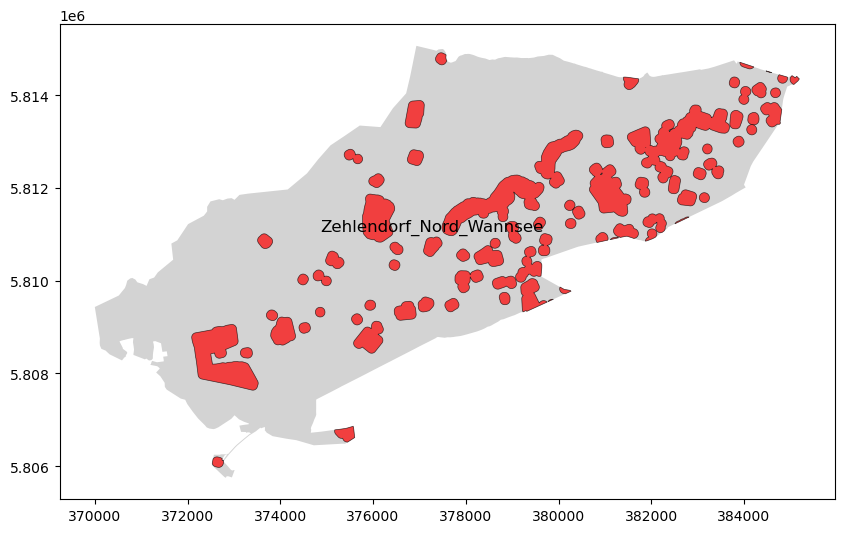

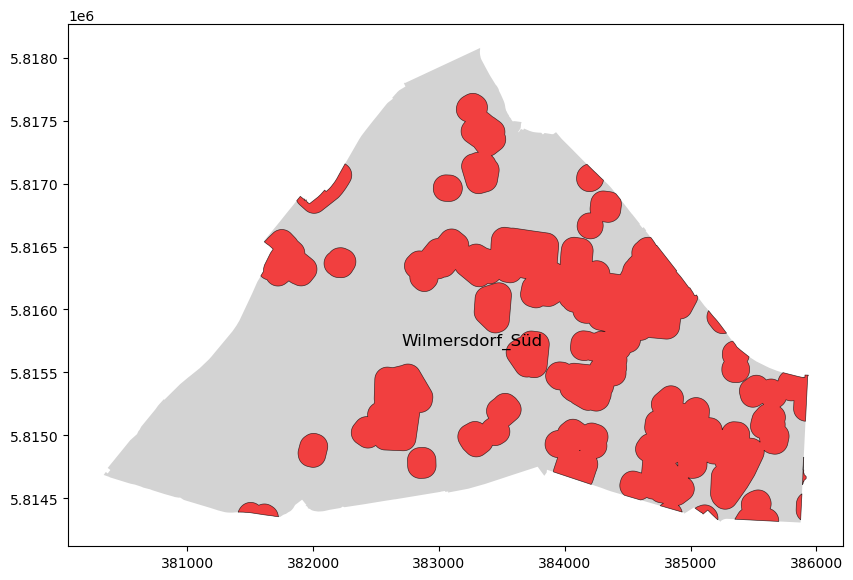

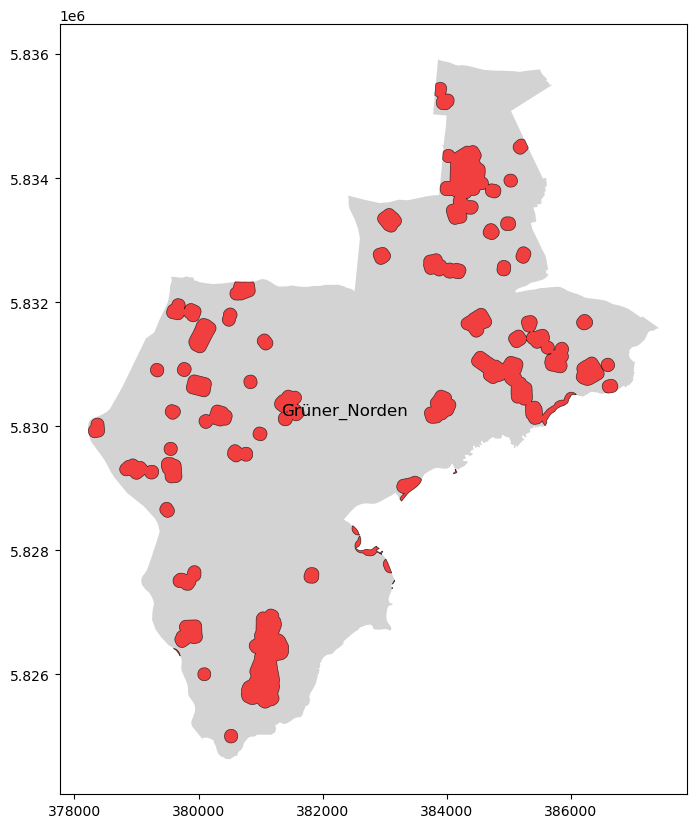

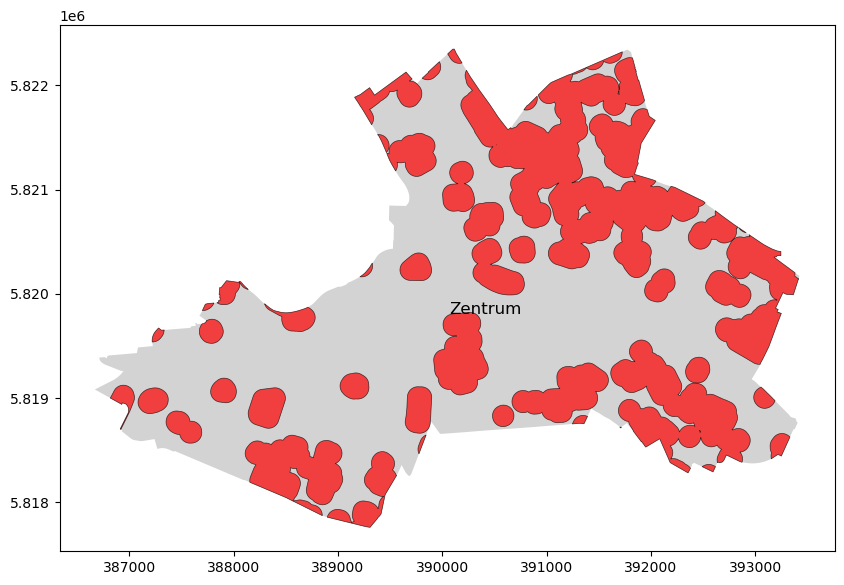

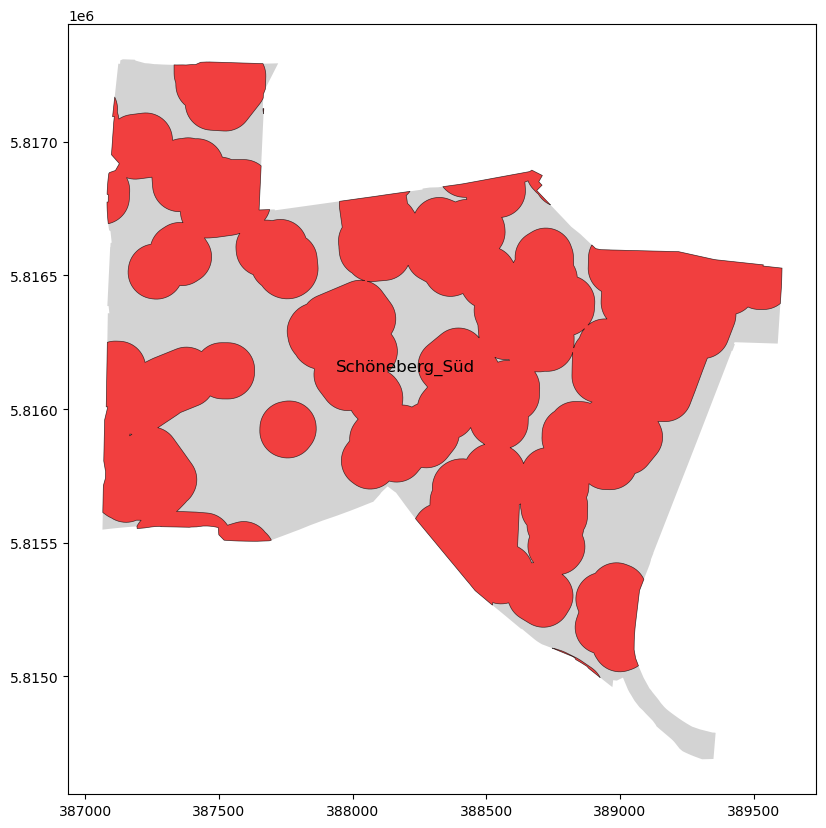

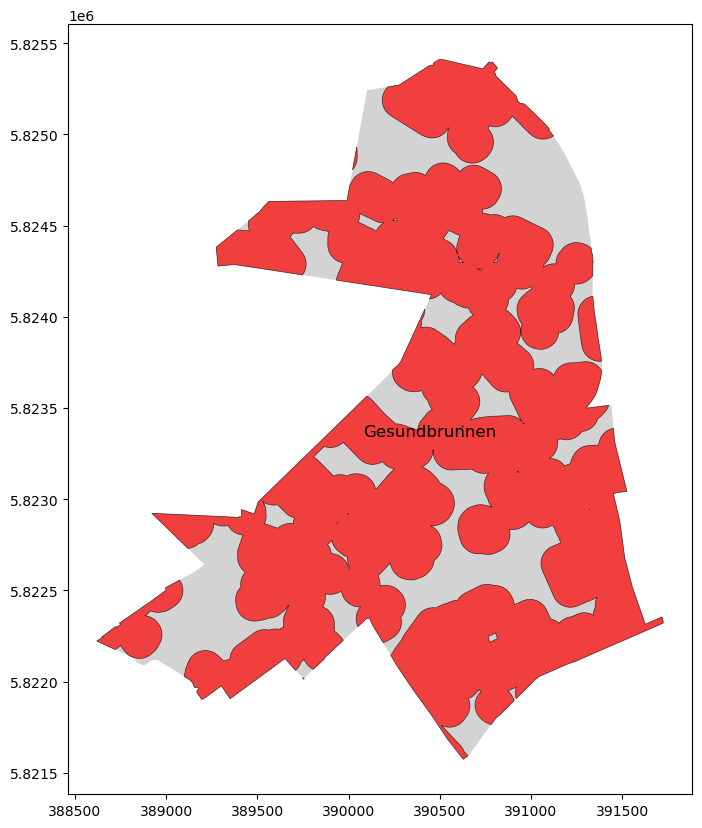

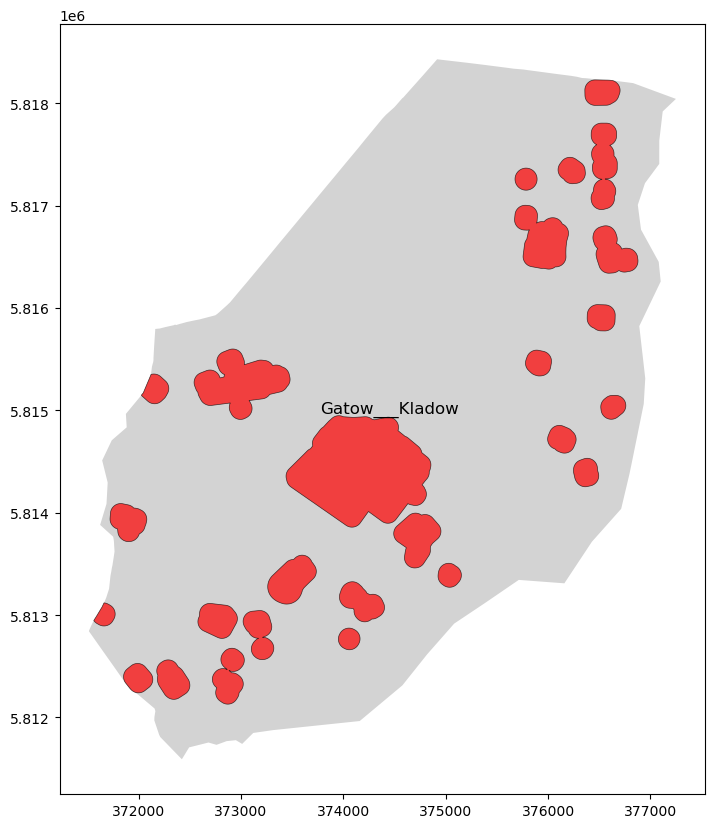

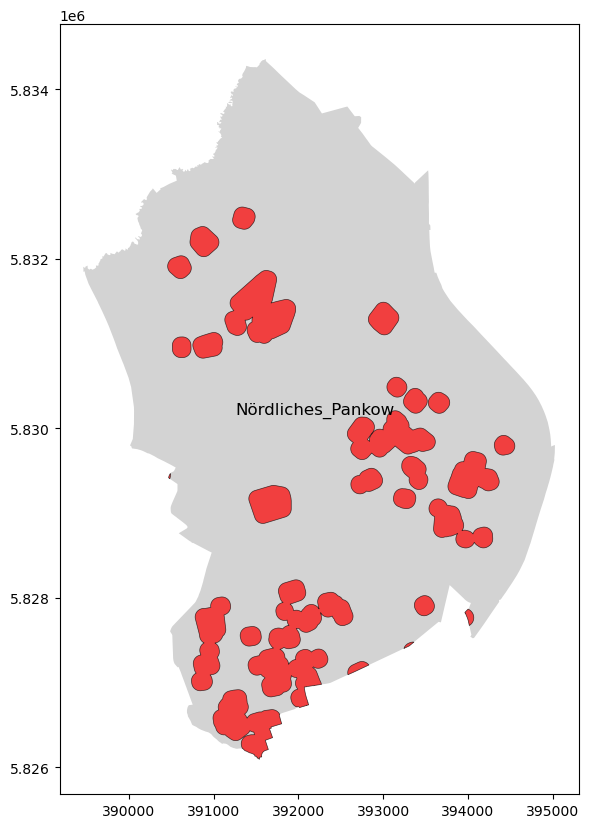

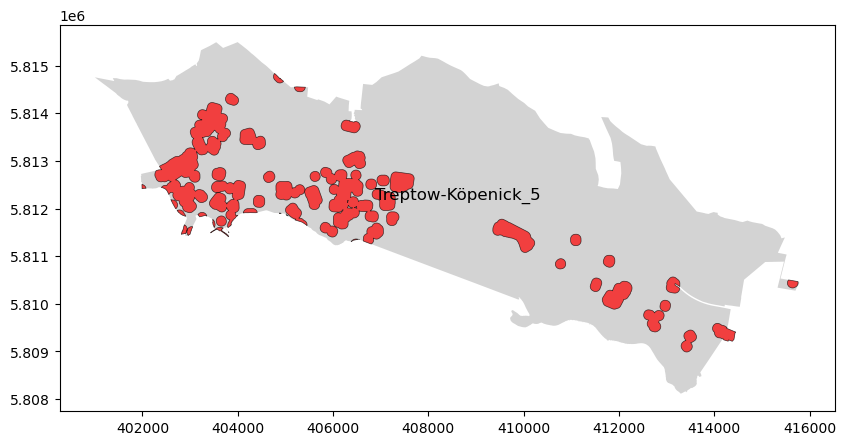

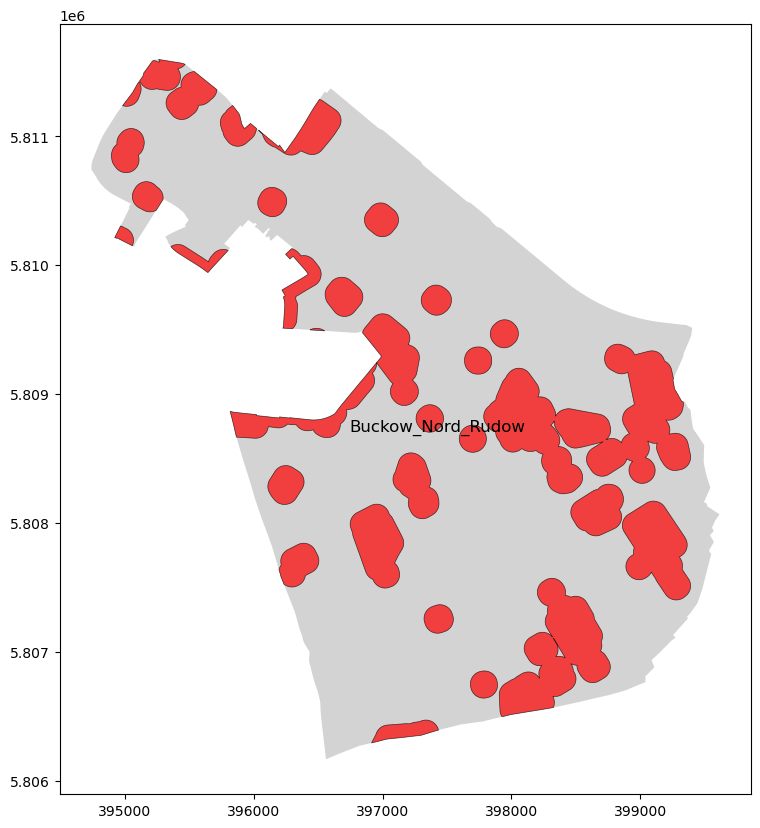

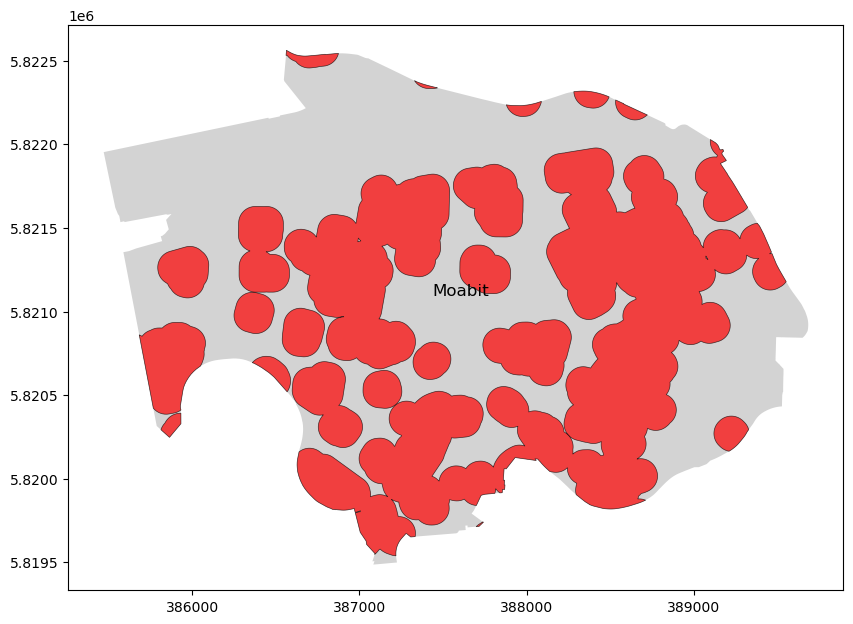

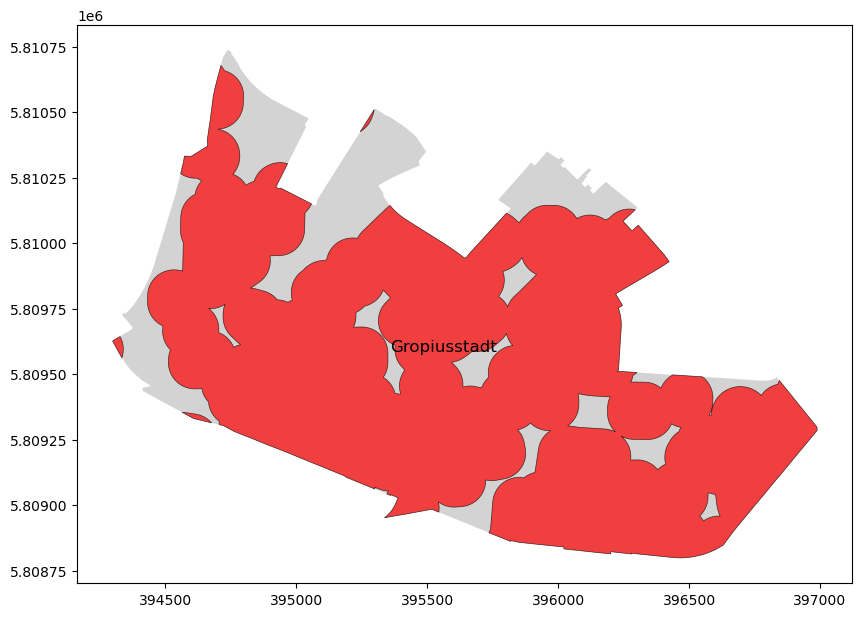

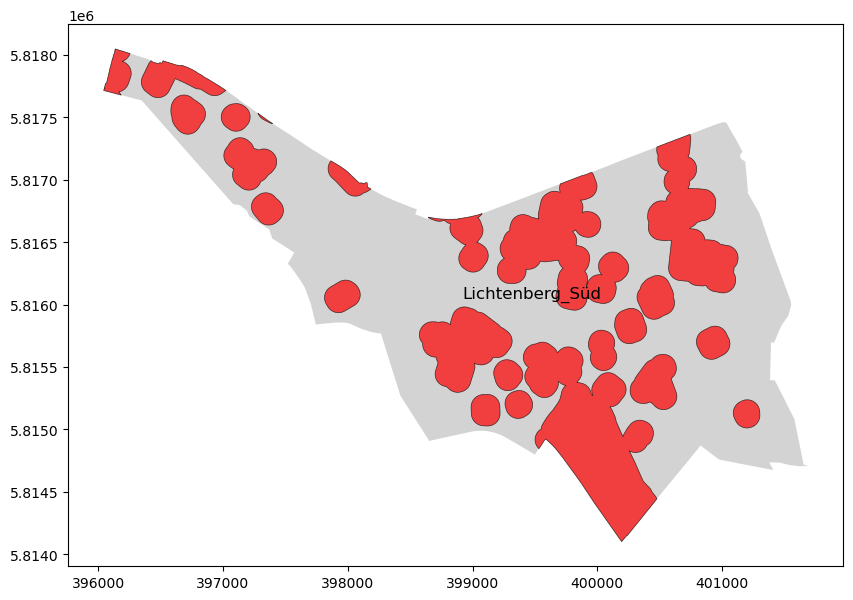

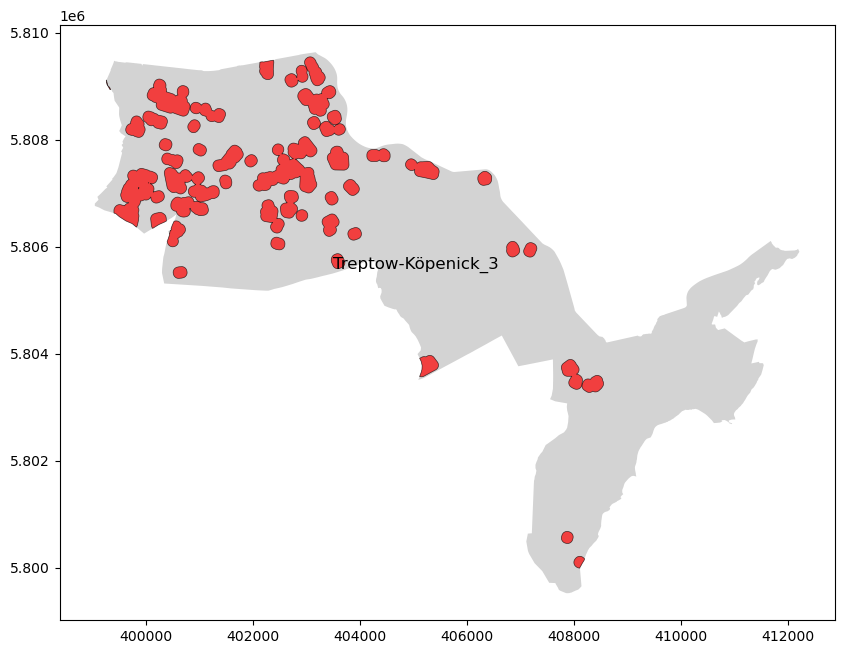

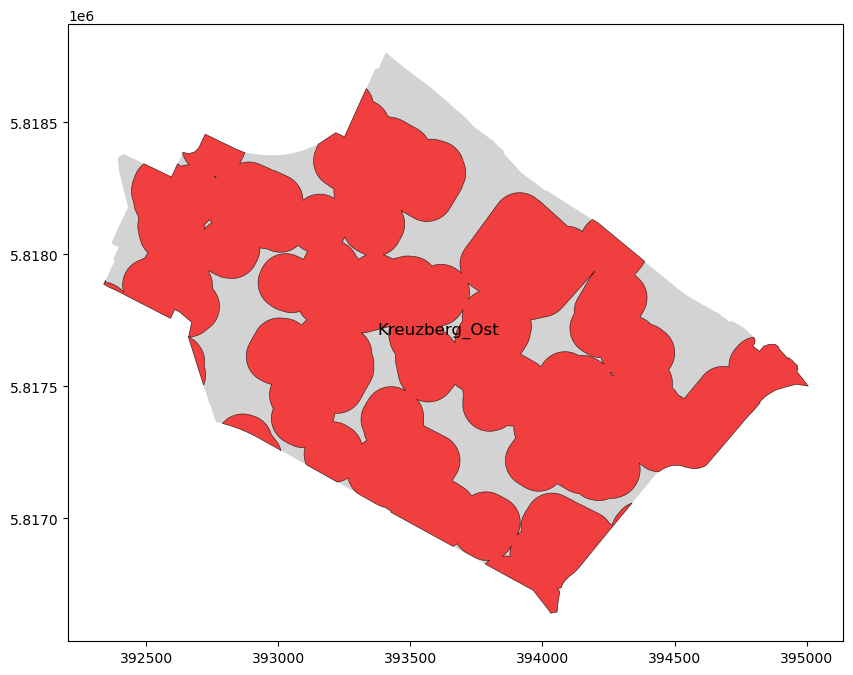

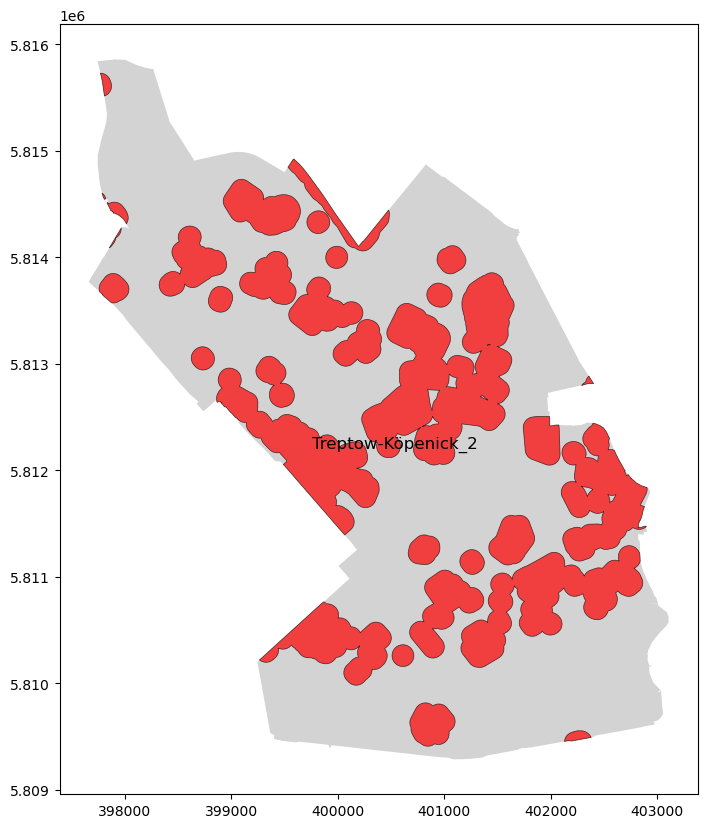

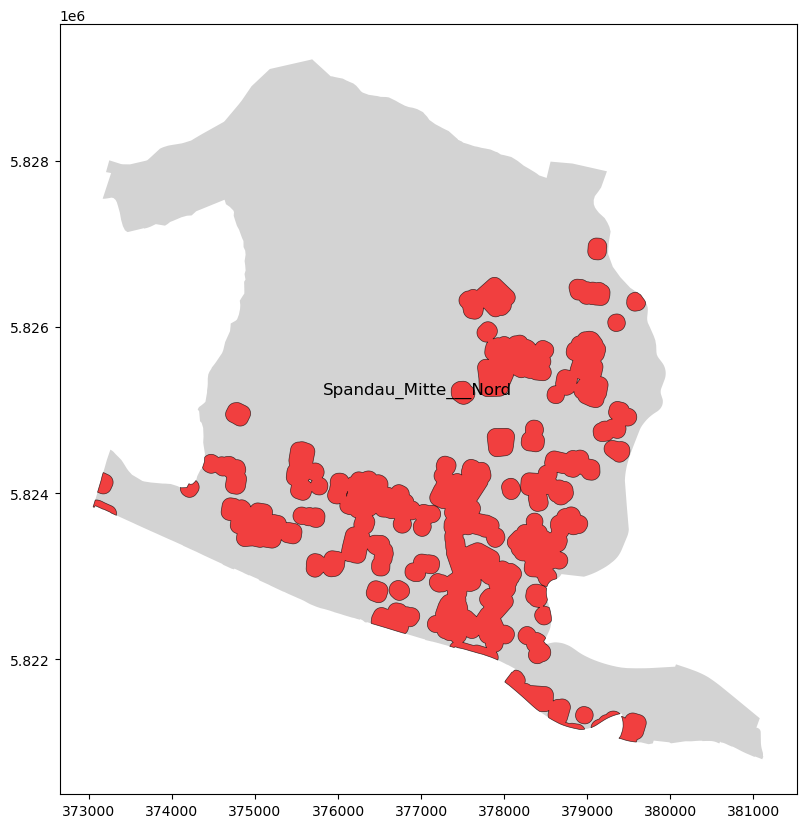

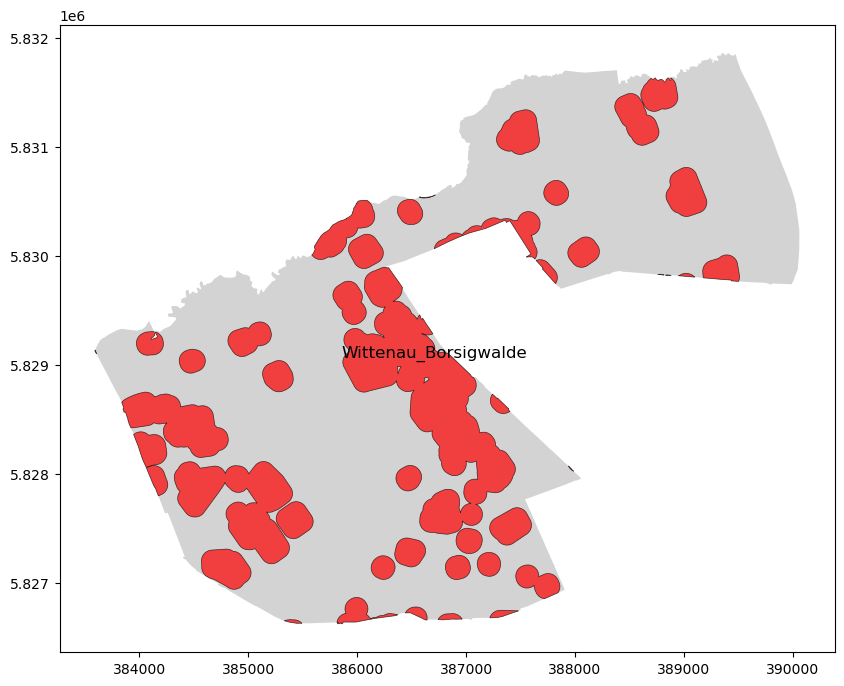

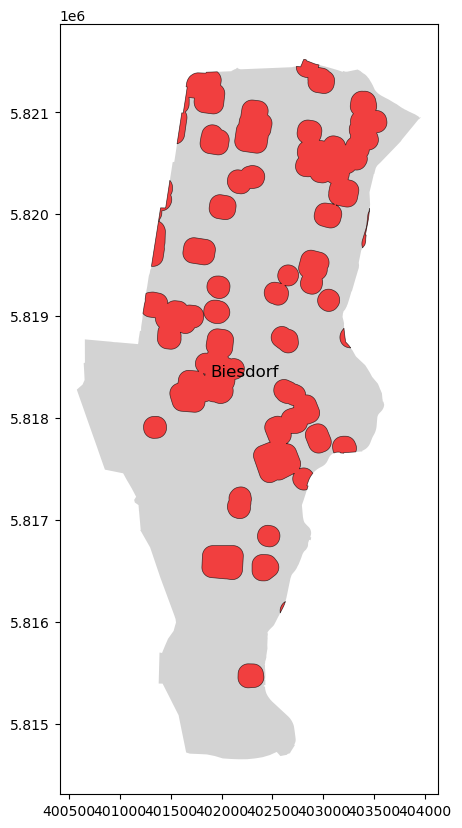

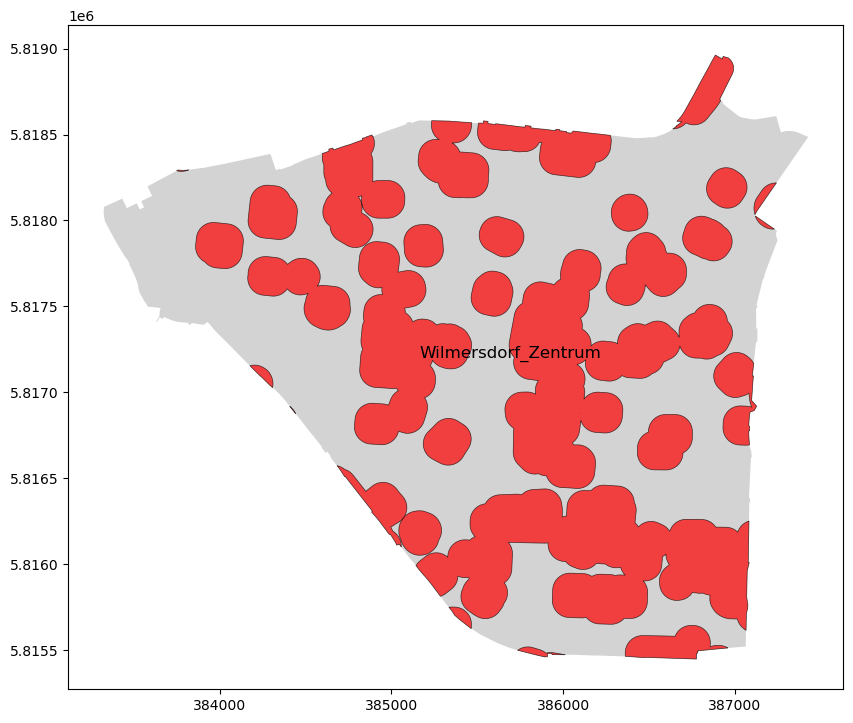

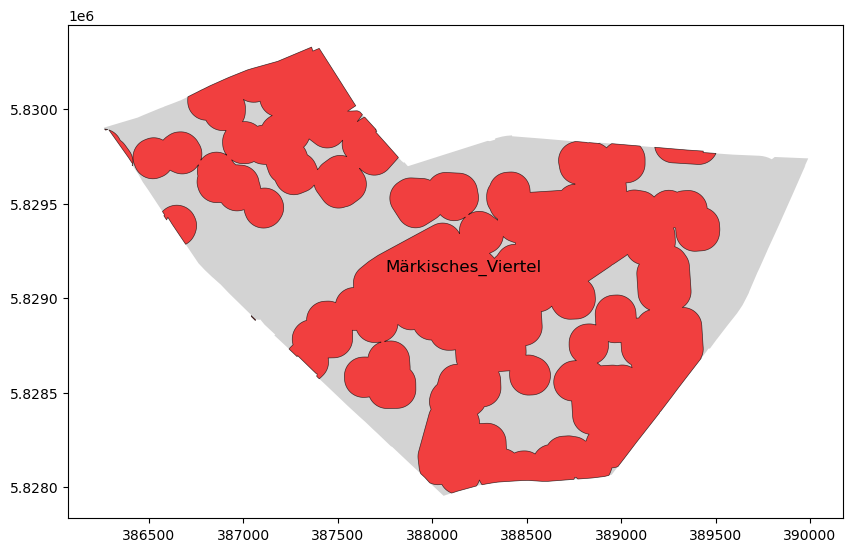

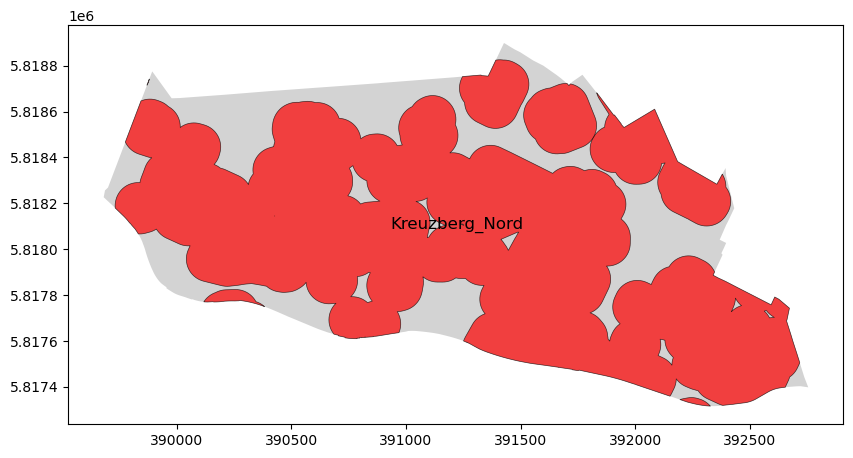

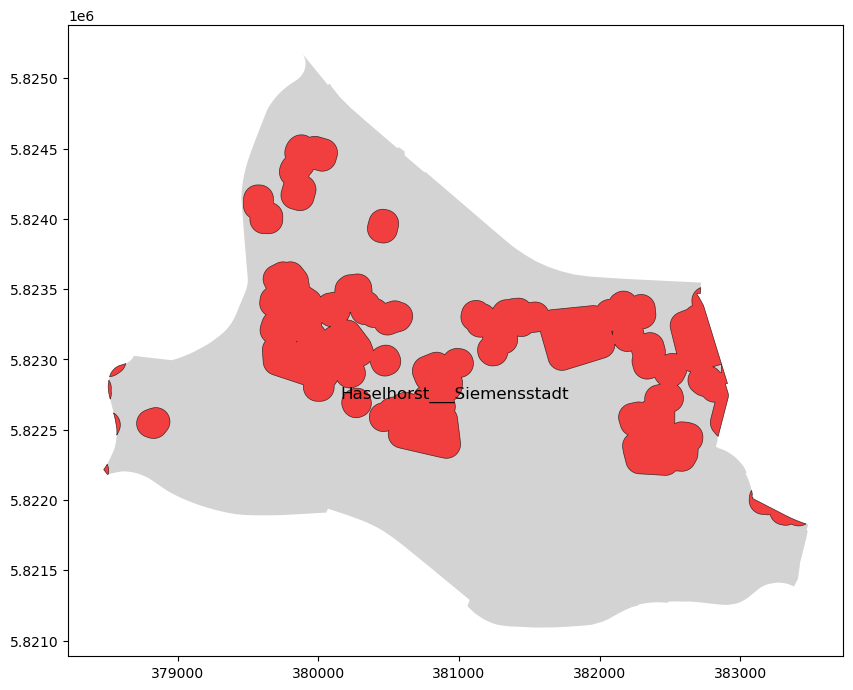

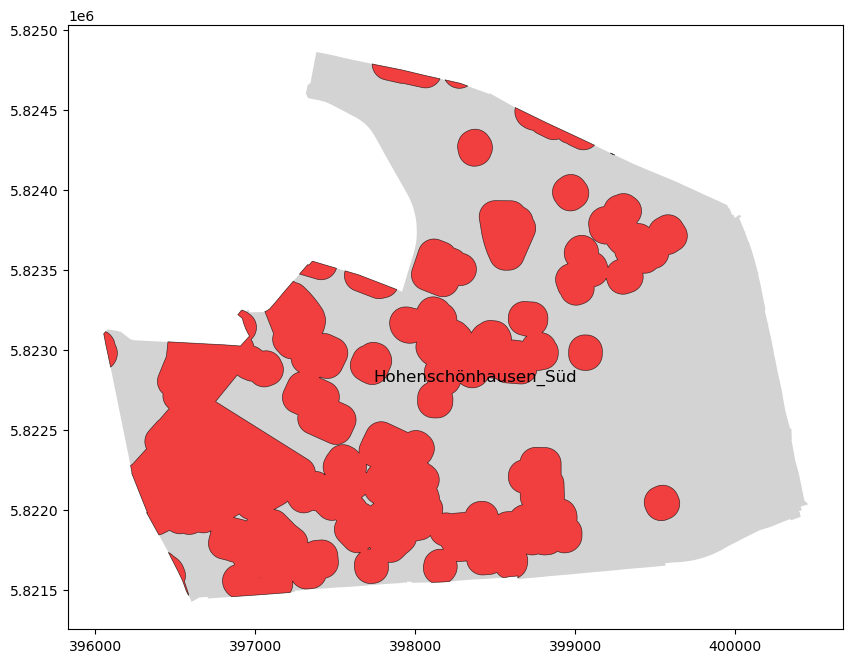

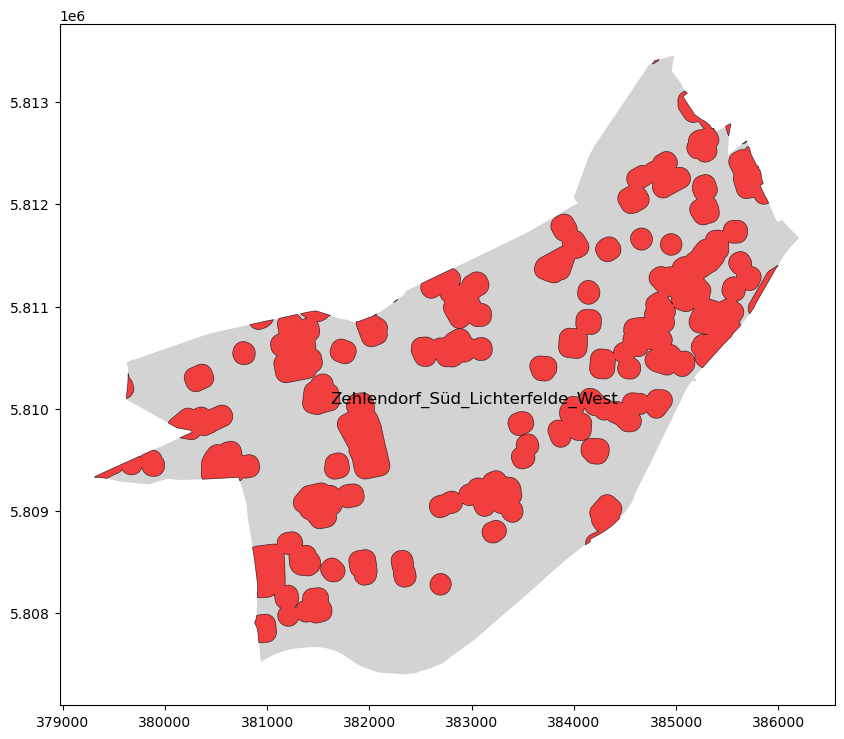

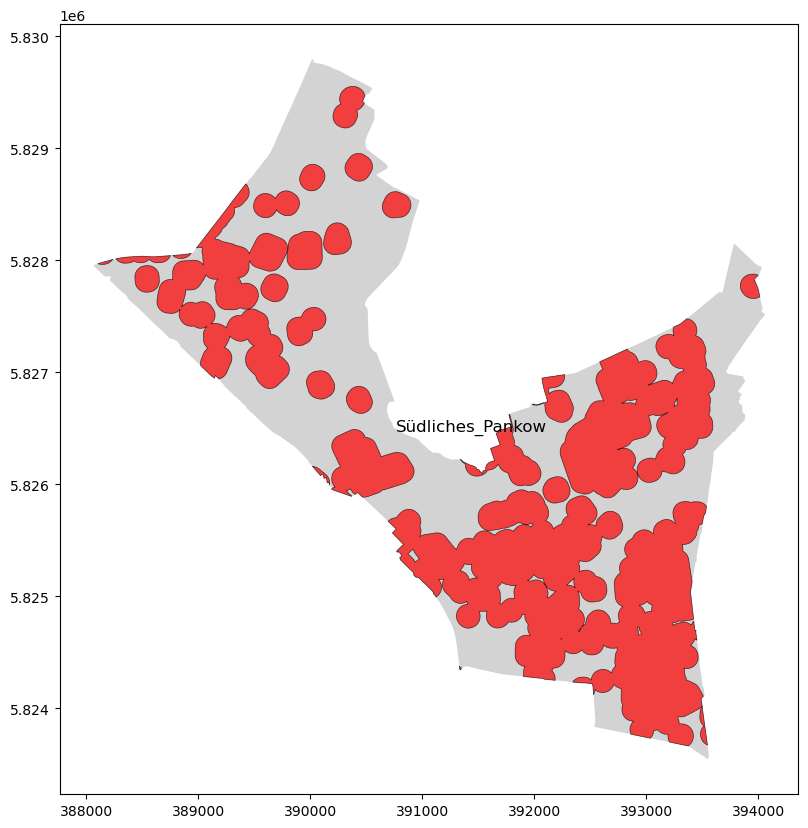

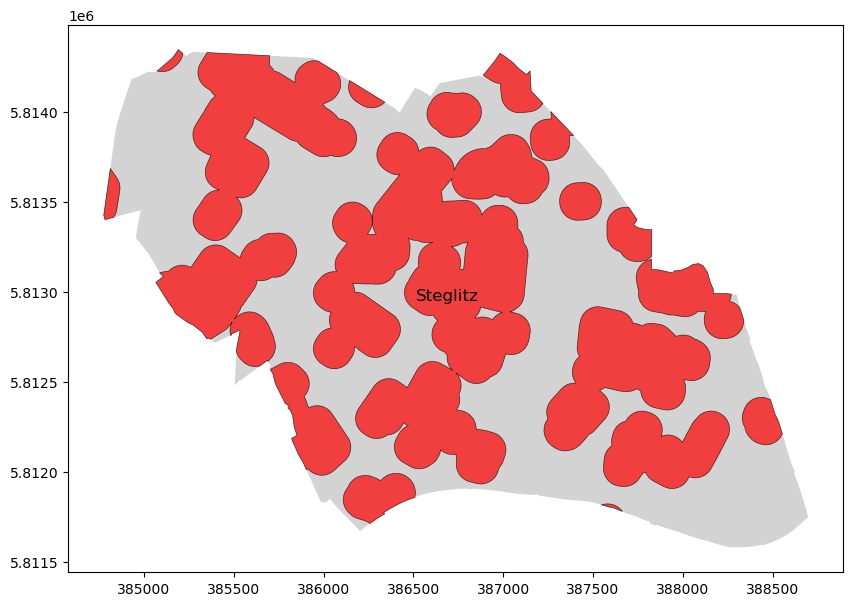

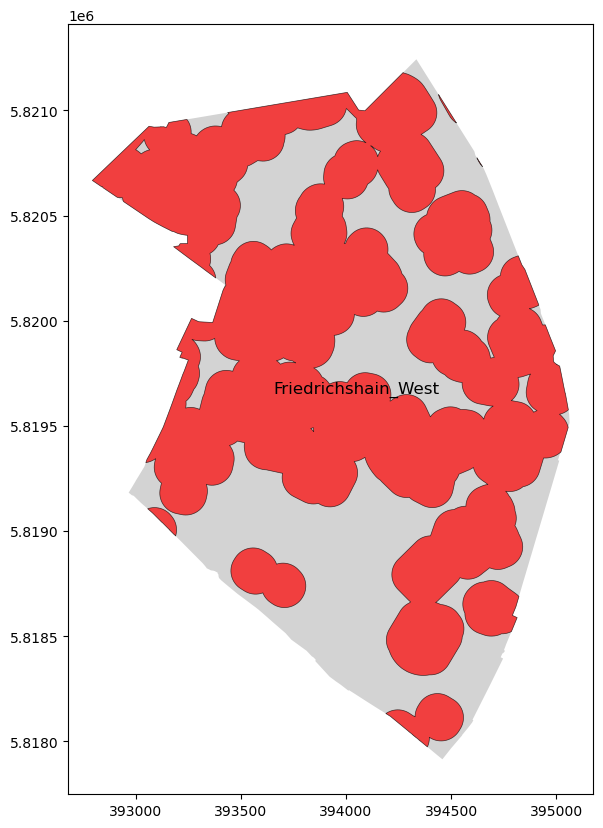

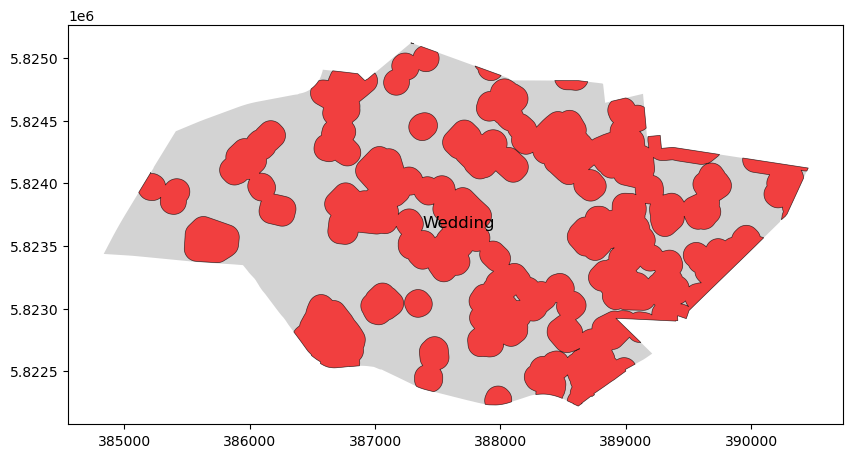

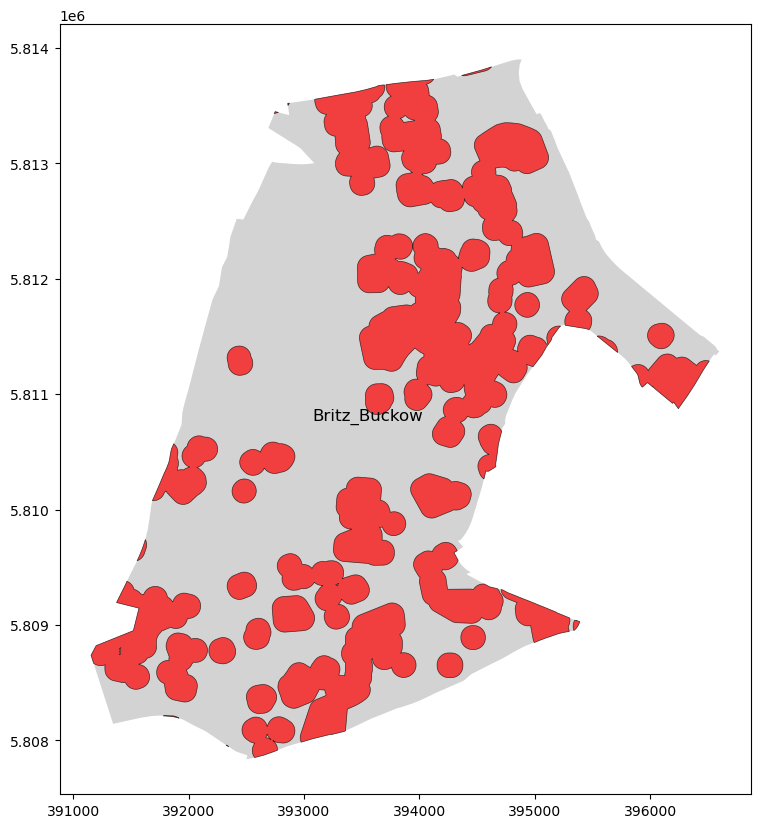

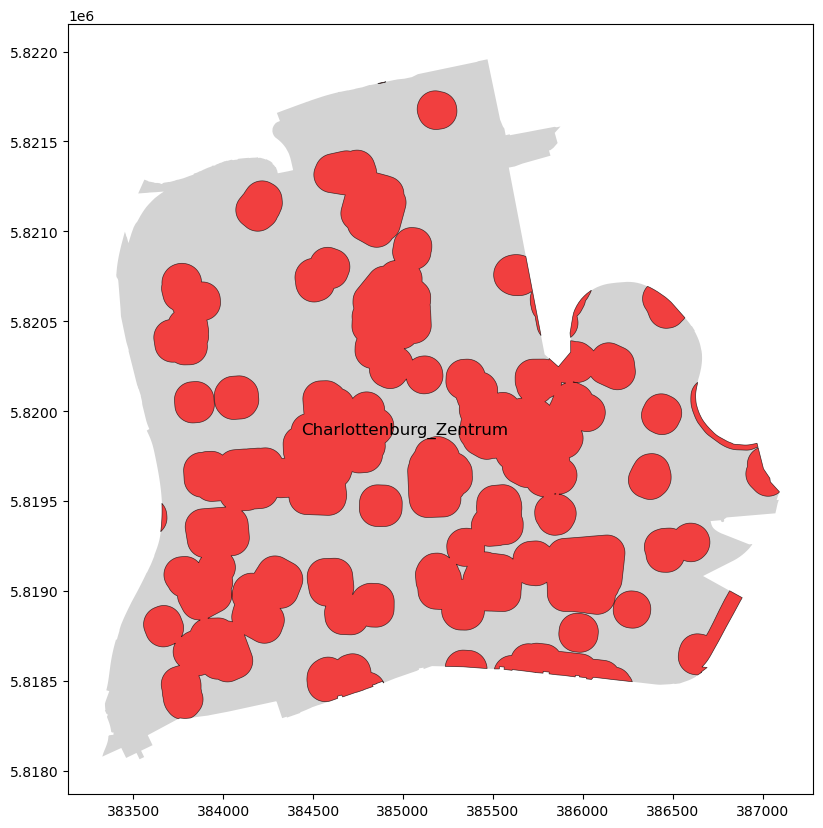

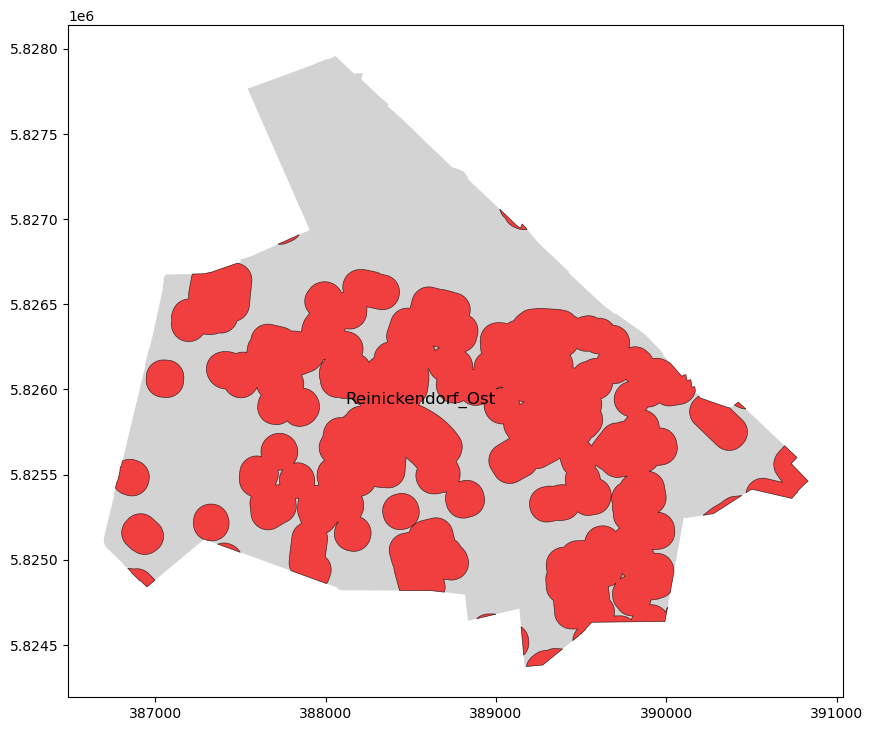

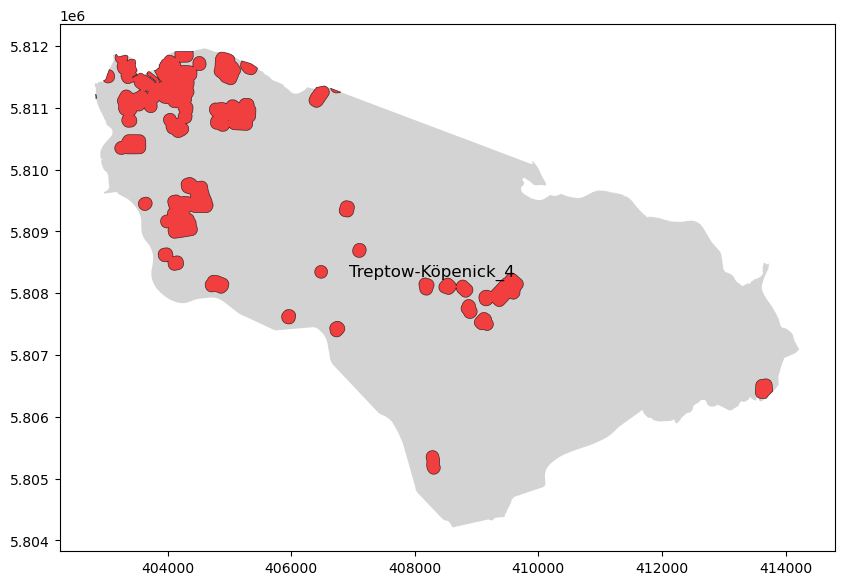

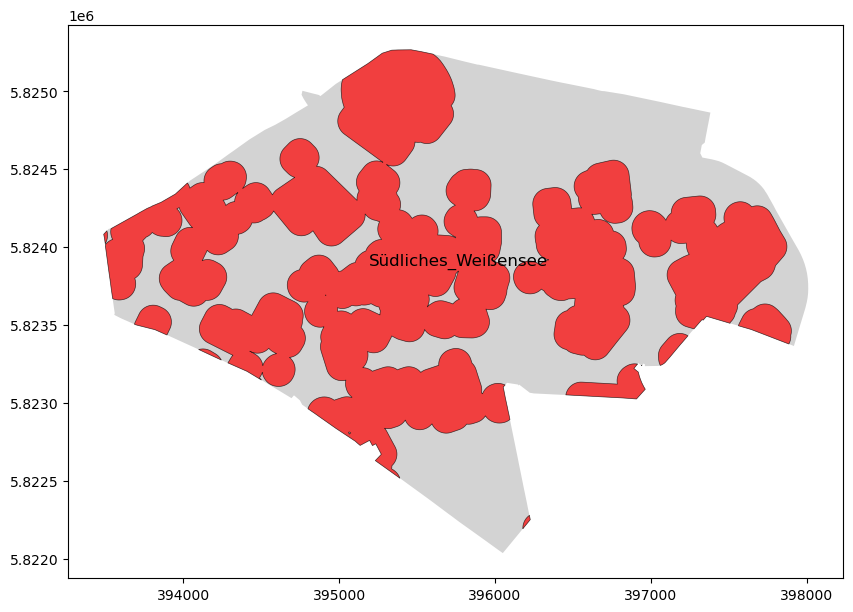

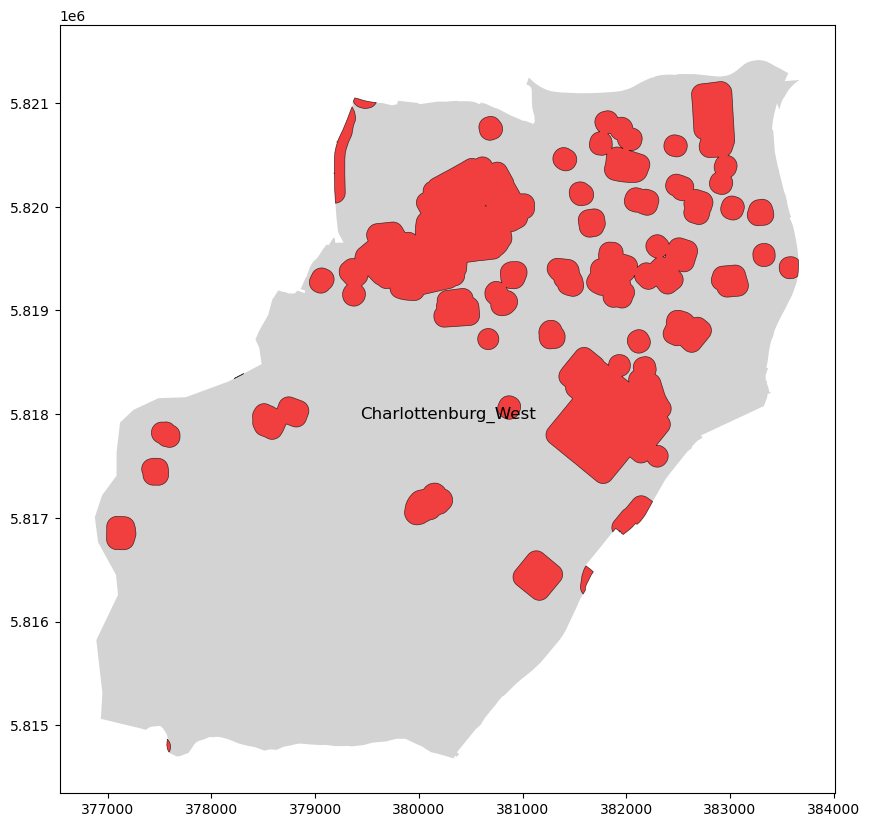

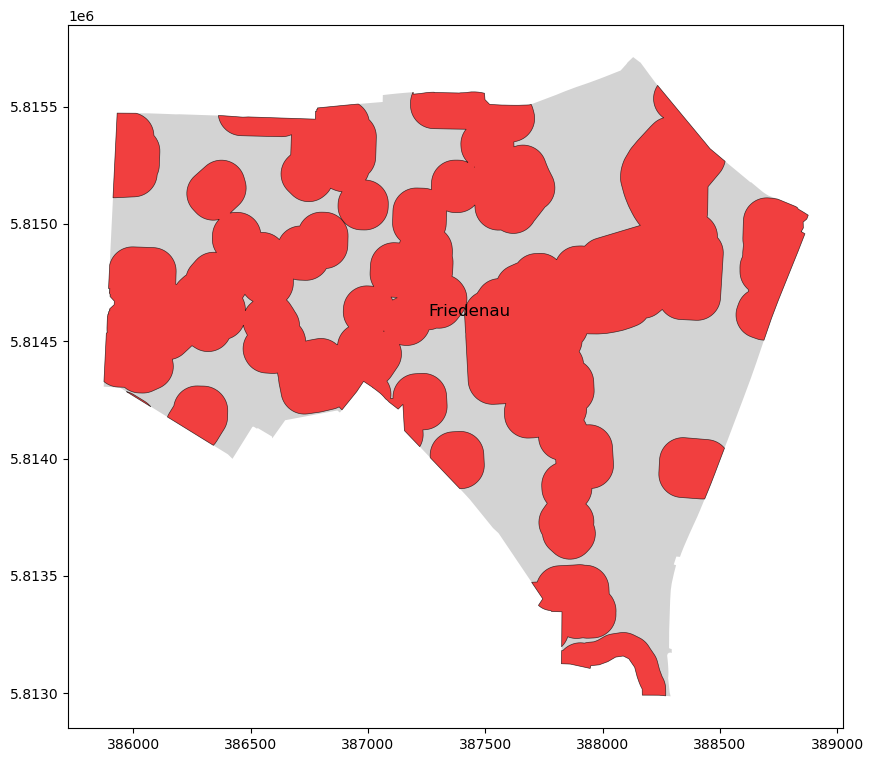

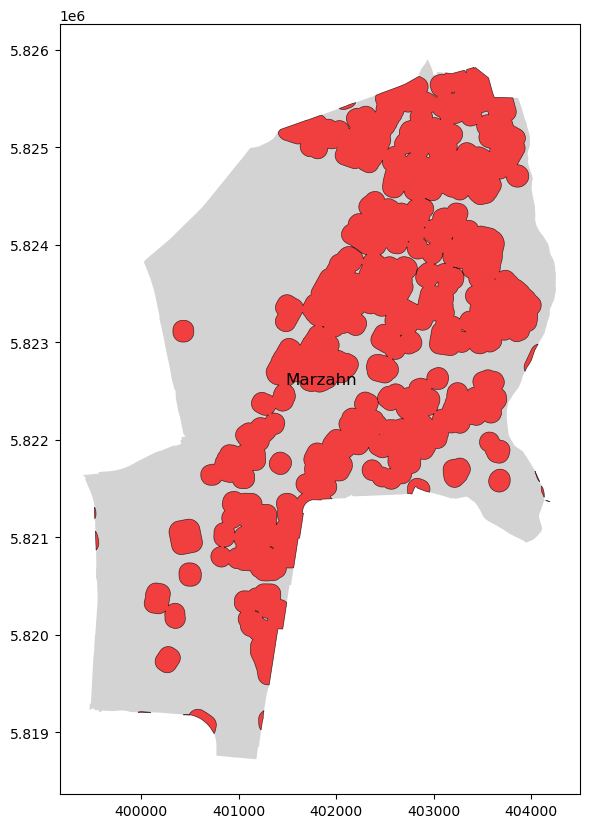

In [29]:
result = admin_areas.apply(
    lambda row: create_cannabisGeom(row, gdf_Cannabis), axis=1
)